# PET Reconstruction Project: Comprehensive Study of Conventional and DL-Based Interative Methods

In [1]:
# First import neccessary package
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the .mat file
file_path = '/content/drive/MyDrive/PET/aphantom.mat'
data = scipy.io.loadmat(file_path)

# Extract data and check keys
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'aphantom'])

Shape of the phantom: (256, 256)


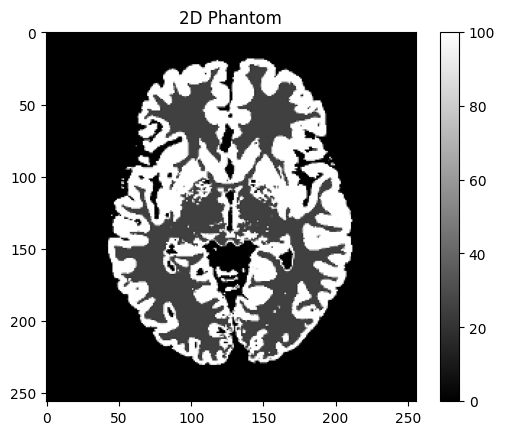

In [3]:
# Extract the phantom data
phantom = data['aphantom']

# Display the shape and visualize the phantom
print(f"Shape of the phantom: {phantom.shape}")

# Visualize the phantom
plt.imshow(phantom, cmap='gray')
plt.title("2D Phantom")
plt.colorbar()
plt.show()

In [4]:
phantom.shape

(256, 256)

## Simulate the Sinogram

In [5]:
from skimage.transform import radon

### Using package

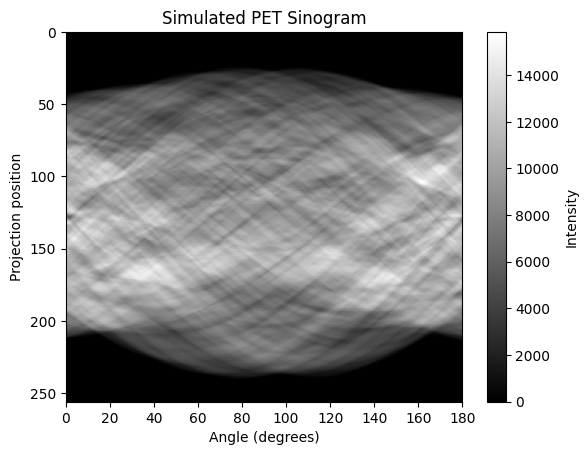

In [6]:
# Define the angles for the PET acquisition
angles = np.linspace(0, 180, max(phantom.shape), endpoint=False)

# Generate the sinogram using the Radon transform
sinogram = radon(phantom, theta=angles, circle=True)

# Visualize the sinogram
plt.imshow(sinogram, cmap='gray', aspect='auto', extent=(0, 180, sinogram.shape[0], 0))
plt.title("Simulated PET Sinogram")
plt.xlabel("Angle (degrees)")
plt.ylabel("Projection position")
plt.colorbar(label="Intensity")
plt.show()

In [26]:
sinogram.shape

(256, 256)

### Using manuscripts

In [7]:
import numpy as np
from scipy.ndimage import rotate

def custom_radon_transform(image, angles, interpolation_order=1):
    """
    Perform the Radon transform manually by rotating the image and summing rows.

    Parameters:
        image : 2D array
            Input image (phantom) to be transformed.
        angles : 1D array
            Angles (in degrees) at which projections are acquired.
        interpolation_order : int, optional
            Order of interpolation for image rotation (default is 1, linear).

    Returns:
        sinogram : 2D array
            Simulated sinogram with projections for all angles.
    """
    # Prepare the output sinogram
    image_size = max(image.shape)
    sinogram = np.zeros((image_size, len(angles)))

    for i, angle in enumerate(angles):
        # Rotate the image by the current angle
        rotated_image = rotate(image, angle, reshape=False, order=interpolation_order, mode='constant', cval=0.0)

        # Sum along the rows to simulate the projection
        projection = np.sum(rotated_image, axis=0)

        # Store the projection in the sinogram
        sinogram[:, i] = projection

    return sinogram

def simulate_2d_pet(image_data, angles=None, noise_level=0, normalize=True, noise_type="Gaussian"):
    """
    Simulates a 2D PET acquisition using a Radon transform and adds Gaussian noises.

    Parameters:
        image_data : 2D array
            Input phantom image or image data.
        angles : 1D array, optional
            Angles at which projections are acquired. Default is 180 evenly spaced angles.
        noise_level : float, optional
            Standard deviation of the Gaussian noise to be added to the sinogram.
            Default is 0 (no noise).
        normalize : bool, optional
            Whether to normalize the image data before generating the sinogram.
            Default is True.

    Returns:
        noisy_sinogram : 2D array
            The simulated sinogram with added noise.
    """
    # Default angles for PET acquisition
    if angles is None:
        angles = np.linspace(0, 180, max(image_data.shape), endpoint=False)

    # Normalize the input image if required
    if normalize:
        image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

    # Perform custom Radon transform
    sinogram = custom_radon_transform(image_data, angles)

    if noise_type == "Gaussian":
        # Add Gaussian noise to the sinogram
        noise = np.random.normal(0, noise_level, sinogram.shape)
        noisy_sinogram = np.maximum(sinogram + noise, 0)  # Ensure non-negative values
    else:
        # Add Poisson noise to the sinogram
        scale_factor = 1e4  # Scale to simulate realistic photon counts
        sinogram_scaled = sinogram * scale_factor
        noisy_sinogram = np.random.poisson(sinogram_scaled) / scale_factor

    return noisy_sinogram

- Setup the image setting
  - Variable `phantom` will be the object

In [8]:
# Example Usage
angles = np.linspace(0, 180, 180, endpoint=False)  # 180 evenly spaced angles
noise_level = 6  # Low noise
noisy_sinogram_custom = simulate_2d_pet(phantom, angles=angles, noise_level=noise_level)

In [9]:
noisy_sinogram_custom.shape

(256, 180)

- Show the image

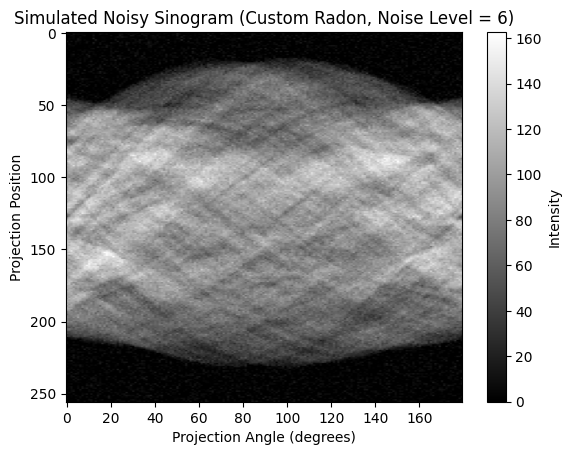

In [10]:
# Visualize the result
import matplotlib.pyplot as plt
plt.imshow(noisy_sinogram_custom, cmap='gray', aspect='auto')
plt.title(f"Simulated Noisy Sinogram (Custom Radon, Noise Level = {noise_level})")
plt.xlabel("Projection Angle (degrees)")
plt.ylabel("Projection Position")
plt.colorbar(label="Intensity")
plt.show()

## Iterative PET Reconstruction from the Sinogram

In this part, we will deepdive into the iterative PET reconstruction methods, including MLEM, MAPEM, and further we will implement a DL based methdo named MAPEM-net, utilized U-NET right after the MAPEM algorithm. Let's start.

In [11]:
sinogram_exp = noisy_sinogram_custom
angles_exp = angles
output_size_exp = phantom.shape[0]

### MLEM

The Maximum Likelihood Expectation-Maximization (MLEM) algorithm reconstructs an image from projection data by iteratively updating the image to maximize the likelihood of observing the measured projections.

**MLEM Formula**
1. **Update Rule**:
   $$
   x^{(k+1)} = x^{(k)} \times \frac{\text{Backproject}\left(\frac{\text{Sinogram}}{\text{Forward Project}(x^{(k)})}\right)}{\text{Backproject}(1)}
   $$
   Where:
   - $x^{(k)}$: Current image estimate at iteration $k$.
   - $\text{Forward Project}(x)$: Line integrals (projections) of the current image $x$.
   - $\text{Sinogram}$: Measured projection data.
   - $\text{Backproject}(y)$: Backprojection operator applied to $y$.
   - $\text{Backproject}(1)$: Normalization factor (backprojection of a sinogram of all ones).

2. **Initialization**:
   - Start with a uniform image $x^{(0)}$ (e.g., all ones).

**Pseudo Code**

1. **Inputs**:
   - Sinogram $S$: Measured projection data.
   - Angles $\theta$: Projection angles.
   - Max iterations $N$: Number of iterations.
   - Image size $M$: Size of the reconstructed image.

2. **Initialization**:
   - Initialize $x^{(0)}$ to a uniform value (e.g., ones).

3. **Precompute Normalization**:
   - Compute $\text{Backproject}(1)$:
     - Create a sinogram of ones (same shape as $S$).
     - Backproject this sinogram to obtain the normalization factor.

4. **Iterative Update**:
   - For $k = 0$ to $N-1$:
     1. Compute the forward projection $F(x^{(k)})$ of the current estimate $x^{(k)}$.
     2. Compute the correction factor:
        $$
        C = \frac{S}{F(x^{(k)})} \quad \text{(element-wise division, avoid division by zero)}.
        $$
     3. Backproject $C$ to obtain $\text{Backproject}(C)$.
     4. Update $x^{(k+1)}$:
        $$
        x^{(k+1)} = x^{(k)} \times \frac{\text{Backproject}(C)}{\text{Backproject}(1)}.
        $$

5. **Output**:
   - Return the final reconstructed image $x^{(N)}$.

**In brief**

1. **Forward Projection**:
   - Compute projections from the current image estimate.
2. **Compute Correction Factor**:
   - Compare measured sinogram and forward projections.
3. **Backprojection**:
   - Distribute the correction factor back into the image space.
4. **Update**:
   - Multiply the current estimate by the normalized backprojected correction.

- First, we consider the basic implement using `skimage`

In [12]:
from skimage.transform import iradon

- Using previous prepared data

#### Using Package

In [29]:
def mlem_reconstruction(sinogram, num_iterations, angles):
    """
    MLEM Reconstruction of a 2D image from sinogram data.

    Parameters:
        sinogram: 2D array
            Input sinogram data.
        num_iterations: int
            Number of iterations for the MLEM algorithm.
        angles: 1D array
            Projection angles used in the sinogram acquisition.

    Returns:
        reconstructed_image: 2D array
            The reconstructed image.
    """
    # Initialize the reconstructed image with a uniform value
    reconstructed_image = np.ones((sinogram.shape[0], sinogram.shape[0]))

    # Precompute the backprojection of ones for normalization
    ones_sinogram = np.ones_like(sinogram)
    normalization_factor = iradon(ones_sinogram, theta=angles, circle=True, filter_name=None)
    epsilon = 1e-12
    image_loop = []

    # Iterative MLEM updates
    for _ in range(num_iterations):
        image_loop.append(reconstructed_image)

        # Compute the forward projection of the current estimate
        forward_projection = radon(reconstructed_image, theta=angles, circle=True)

        # Compute the correction factor
        correction_factor = np.divide(sinogram, forward_projection, out=np.zeros_like(sinogram), where=(forward_projection > 1e-10))

        # Backproject the correction factor
        backprojection = iradon(correction_factor, theta=angles, circle=True, filter_name=None)

        # Update the reconstructed image
        reconstructed_image *= backprojection
        reconstructed_image /= (normalization_factor + epsilon)

    return reconstructed_image, image_loop

In [30]:
# Set parameters for reconstruction
reconstructed_image, image_loop = mlem_reconstruction(sinogram_exp, num_iterations=20, angles=angles)

- Visualize the result

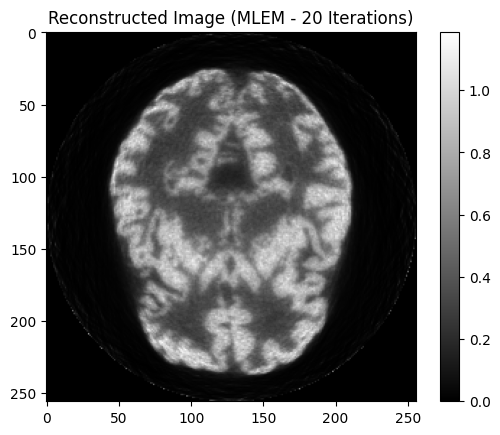

In [31]:
# Visualize the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f"Reconstructed Image (MLEM - 20 Iterations)")
plt.colorbar()
plt.show()

#### Using Manuscripts

In [32]:
import numpy as np
from scipy.ndimage import rotate

In [33]:
def radon_transform(image, angles, interpolation_order=1):
    """
    Perform the Radon transform manually by rotating the image and summing rows.
    """
    image_size = max(image.shape)
    sinogram = np.zeros((image_size, len(angles)))

    for i, angle in enumerate(angles):
        rotated_image = rotate(image, angle, reshape=False, order=interpolation_order, mode='constant', cval=0.0)
        projection = np.sum(rotated_image, axis=0)
        sinogram[:, i] = projection

    return sinogram

def backprojection(sinogram, angles, output_size):
    """
    Perform backprojection manually by distributing sinogram values across angles.
    """
    reconstructed_image = np.zeros((output_size, output_size))

    for i, angle in enumerate(angles):
        # Create a 2D projection of the current sinogram column
        projection = np.tile(sinogram[:, i], (output_size, 1))

        # Rotate the projection back to the original angle
        backprojected_image = rotate(projection, -angle, reshape=False, order=1, mode='constant', cval=0.0)

        # Accumulate contributions from all angles
        reconstructed_image += backprojected_image

    return reconstructed_image

def mlem(sinogram, angles, num_iterations, output_size):
    """
    Implement the MLEM algorithm in pure Python.
    """
    # Initialize the image with uniform values
    reconstructed_image = np.ones((output_size, output_size))

    # Precompute the backprojection of ones for normalization
    ones_sinogram = np.ones_like(sinogram)
    normalization_factor = backprojection(ones_sinogram, angles, output_size)

    image_loop = []

    for _ in range(num_iterations):
        # Forward projection of the current estimate
        image_loop.append(reconstructed_image)
        forward_projection = radon_transform(reconstructed_image, angles)

        # Compute the correction factor
        correction_factor = np.divide(
            sinogram, forward_projection,
            out=np.zeros_like(sinogram),
            where=forward_projection != 0
        )

        # Backproject the correction factor
        backprojected_correction = backprojection(correction_factor, angles, output_size)

        # Update the reconstructed image
        reconstructed_image *= backprojected_correction / normalization_factor

    return reconstructed_image, image_loop

In [34]:
sinogram_exp.shape

(256, 180)

In [35]:
# Perform MLEM reconstruction
reconstructed_image, image_loop = mlem(
    sinogram=sinogram_exp,
    angles=angles,
    num_iterations=10,
    output_size=output_size_exp
)

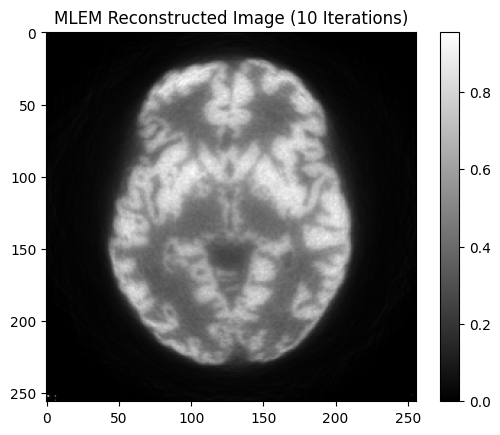

In [36]:
# Visualize the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f"MLEM Reconstructed Image (10 Iterations)")
plt.colorbar()
plt.show()

### MAPEM

**Pseudo Code for MAPEM Algorithm**

The **Maximum A Posteriori Expectation-Maximization (MAPEM)** algorithm is an extension of MLEM. It incorporates a prior (regularization term) to penalize unlikely solutions, balancing noise reduction and detail preservation.

---

**MAPEM Formula**
1. **Update Rule**:
   $$
   x^{(k+1)} = x^{(k)} \times \frac{\text{Backproject}\left(\frac{\text{Sinogram}}{\text{Forward Project}(x^{(k)})}\right)}{\text{Backproject}(1) + \lambda \nabla R(x^{(k)})}
   $$
   Where:
   - $x^{(k)}$: Current image estimate at iteration $k$.
   - $\text{Forward Project}(x)$: Line integrals (projections) of the current image $x$.
   - $\text{Sinogram}$: Measured projection data.
   - $\text{Backproject}(y)$: Backprojection operator applied to $y$.
   - $\text{Backproject}(1)$: Normalization factor (backprojection of a sinogram of all ones).
   - $\lambda$: Regularization strength controlling the weight of the prior.
   - $R(x)$: Regularization term (prior) applied to the image $x$.
   - $\nabla R(x)$: Gradient of the prior.

2. **Initialization**:
   - Start with a uniform image $x^{(0)}$ (e.g., all ones).

---

**Pseudo Code**

1. **Inputs**:
   - Sinogram $S$: Measured projection data.
   - Angles $\theta$: Projection angles.
   - Max iterations $N$: Number of iterations.
   - Regularization strength $\lambda$.
   - Image size $M$: Size of the reconstructed image.
   - Prior function $R(x)$: Regularization term.

2. **Initialization**:
   - Initialize $x^{(0)}$ to a uniform value (e.g., ones).

3. **Precompute Normalization**:
   - Compute $\text{Backproject}(1)$:
     - Create a sinogram of ones (same shape as $S$).
     - Backproject this sinogram to obtain the normalization factor.

4. **Iterative Update**:
   - For $k = 0$ to $N-1$:
     1. Compute the forward projection $F(x^{(k)})$ of the current estimate $x^{(k)}$.
     2. Compute the correction factor:
        $$
        C = \frac{S}{F(x^{(k)})} \quad \text{(element-wise division, avoid division by zero)}.
        $$
     3. Backproject $C$ to obtain $\text{Backproject}(C)$.
     4. Compute the prior gradient $\nabla R(x^{(k)})$.
     5. Update $x^{(k+1)}$:
        $$
        x^{(k+1)} = x^{(k)} \times \frac{\text{Backproject}(C)}{\text{Backproject}(1) + \lambda \nabla R(x^{(k)})}.
        $$

5. **Output**:
   - Return the final reconstructed image $x^{(N)}$.

---

**Key Components**
1. **Prior Function $R(x)$**:
   - Common priors include:
     - **Sparse Priors**: Promote sparsity in the image.
     - **Quadratic Prior**: Promotes smoothness.
       $$
       R(x) = \frac{1}{2} \sum_{i,j} (x_{i,j} - x_{i+1,j})^2 + (x_{i,j} - x_{i,j+1})^2
       $$
     - **Huber Loss**: Edge-preserving prior.
       
$$
R(x)=\left\{
\begin{array}{rcl}
x^2 &  & {|x| \leq \delta}\\
\delta(|x| - \frac{\delta}{2}) & & {|x| > \delta}
\end{array} \right.
$$

2. **Regularization Strength $\lambda$**:
   - Controls the trade-off between data fidelity and regularization.

3. **Gradient of Prior $\nabla R(x)$**:
   - Derivative of the regularization term, e.g., for quadratic priors:
     $$
     \nabla R(x) \approx \sum_{\text{neighbors}} (x_{i,j} - x_{\text{neighbor}})
     $$

Now, we implement the MAPEM using `skimage`

#### Using package

In [37]:
def mapem_reconstruction(sinogram, num_iterations, angles, lambda_reg=0.1):
    """
    MAPEM Reconstruction of a 2D image from sinogram data.

    Parameters:
        sinogram: 2D array
            Input sinogram data.
        num_iterations: int
            Number of iterations for the MAPEM algorithm.
        angles: 1D array
            Projection angles used in the sinogram acquisition.
        lambda_reg: float
            Regularization parameter controlling the strength of the prior.

    Returns:
        reconstructed_image: 2D array
            The reconstructed image.
    """
    # Initialize the reconstructed image with a uniform value
    reconstructed_image = np.ones((sinogram.shape[0], sinogram.shape[0]))

    # Precompute the backprojection of ones for normalization
    ones_sinogram = np.ones_like(sinogram)
    normalization_factor = iradon(ones_sinogram, theta=angles, circle=True, filter_name=None)

    # Define a simple quadratic penalty function gradient for smoothness
    def penalty_gradient(image):
        grad = np.zeros_like(image)
        grad[:-1, :] += image[:-1, :] - image[1:, :]  # Vertical differences
        grad[1:, :] += image[1:, :] - image[:-1, :]
        grad[:, :-1] += image[:, :-1] - image[:, 1:]  # Horizontal differences
        grad[:, 1:] += image[:, 1:] - image[:, :-1]
        return grad

    def huber_gradient(image, delta):
        """
        Compute the Huber loss gradient for regularization.

        Parameters:
            image: 2D array
                The input image for which to compute the gradient.
            delta: float
                The Huber loss threshold.

        Returns:
            grad: 2D array
                The computed Huber loss gradient.
        """
        grad = np.zeros_like(image)

        # Compute vertical differences
        vertical_diff = image[:-1, :] - image[1:, :]
        grad[:-1, :] += np.where(np.abs(vertical_diff) <= delta, vertical_diff, delta * np.sign(vertical_diff))
        grad[1:, :] -= np.where(np.abs(vertical_diff) <= delta, vertical_diff, delta * np.sign(vertical_diff))

        # Compute horizontal differences
        horizontal_diff = image[:, :-1] - image[:, 1:]
        grad[:, :-1] += np.where(np.abs(horizontal_diff) <= delta, horizontal_diff, delta * np.sign(horizontal_diff))
        grad[:, 1:] -= np.where(np.abs(horizontal_diff) <= delta, horizontal_diff, delta * np.sign(horizontal_diff))

        return grad

    image_loop = []
    # Iterative MAPEM updates
    for _ in range(num_iterations):
        image_loop.append(reconstructed_image)

        # Compute the forward projection of the current estimate
        forward_projection = radon(reconstructed_image, theta=angles, circle=True)

        # Compute the correction factor
        correction_factor = np.divide(sinogram, forward_projection, out=np.zeros_like(sinogram), where=forward_projection != 0)

        # Backproject the correction factor
        backprojection = iradon(correction_factor, theta=angles, circle=True, filter_name=None)

        # Add the regularization term
        reg_term = 1 - lambda_reg * penalty_gradient(reconstructed_image)
        reg_term = np.clip(reg_term, 0.1, 10)  # Stabilize regularization term

        # Update the reconstructed image
        reconstructed_image *= backprojection / (normalization_factor + reg_term)

    return reconstructed_image, image_loop

In [38]:
# Set parameters for MAPEM reconstruction
lambda_reg = 0.05  # Regularization strength
num_iterations = 20

In [39]:
# Perform MAPEM reconstruction
reconstructed_image, image_loop = mapem_reconstruction(
    sinogram=sinogram_exp,
    num_iterations=num_iterations,
    angles=angles_exp,
    lambda_reg=lambda_reg
)

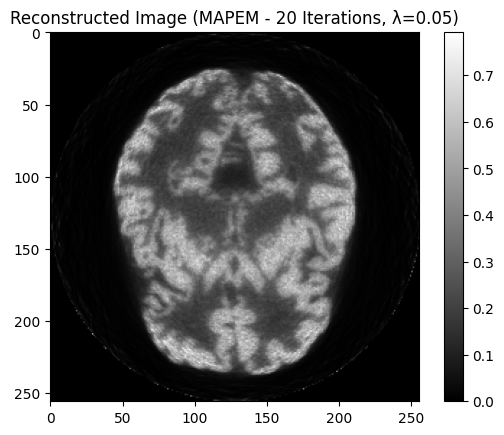

In [40]:
# Visualize the MAPEM reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f"Reconstructed Image (MAPEM - {num_iterations} Iterations, λ={lambda_reg})")
plt.colorbar()
plt.show()

#### Using manuscripts

In [41]:
def radon_transform(image, angles, interpolation_order=1): # radon
    """
    Perform the Radon transform manually by rotating the image and summing rows.
    """
    image_size = max(image.shape)
    sinogram = np.zeros((image_size, len(angles)))

    for i, angle in enumerate(angles):
        rotated_image = rotate(image, angle, reshape=False, order=interpolation_order, mode='constant', cval=0.0)
        projection = np.sum(rotated_image, axis=0)
        sinogram[:, i] = projection

    return sinogram

def backprojection(sinogram, angles, output_size): # iradon
    """
    Perform backprojection manually by distributing sinogram values across angles.
    """
    reconstructed_image = np.zeros((output_size, output_size))

    for i, angle in enumerate(angles):
        # Create a 2D projection of the current sinogram column
        projection = np.tile(sinogram[:, i], (output_size, 1))

        # Rotate the projection back to the original angle
        backprojected_image = rotate(projection, -angle, reshape=False, order=1, mode='constant', cval=0.0)

        # Accumulate contributions from all angles
        reconstructed_image += backprojected_image

    return reconstructed_image

def mapem(sinogram, angles, num_iterations, output_size, lambda_reg):
    """
    Implement the MLEM algorithm in pure Python.
    """
    # Initialize the image with uniform values
    reconstructed_image = np.ones((output_size, output_size))

    # Precompute the backprojection of ones for normalization
    ones_sinogram = np.ones_like(sinogram)
    normalization_factor = backprojection(ones_sinogram, angles, output_size)

    image_loop = []

    # Define a simple quadratic penalty function gradient for smoothness
    def penalty_gradient(image):
        grad = np.zeros_like(image)
        grad[:-1, :] += image[:-1, :] - image[1:, :]  # Vertical differences
        grad[1:, :] += image[1:, :] - image[:-1, :]
        grad[:, :-1] += image[:, :-1] - image[:, 1:]  # Horizontal differences
        grad[:, 1:] += image[:, 1:] - image[:, :-1]
        return grad

    def huber_gradient(image, delta):
        """
        Compute the Huber loss gradient for regularization.

        Parameters:
            image: 2D array
                The input image for which to compute the gradient.
            delta: float
                The Huber loss threshold.

        Returns:
            grad: 2D array
                The computed Huber loss gradient.
        """
        grad = np.zeros_like(image)

        # Compute vertical differences
        vertical_diff = image[:-1, :] - image[1:, :]
        grad[:-1, :] += np.where(np.abs(vertical_diff) <= delta, vertical_diff, delta * np.sign(vertical_diff))
        grad[1:, :] -= np.where(np.abs(vertical_diff) <= delta, vertical_diff, delta * np.sign(vertical_diff))

        # Compute horizontal differences
        horizontal_diff = image[:, :-1] - image[:, 1:]
        grad[:, :-1] += np.where(np.abs(horizontal_diff) <= delta, horizontal_diff, delta * np.sign(horizontal_diff))
        grad[:, 1:] -= np.where(np.abs(horizontal_diff) <= delta, horizontal_diff, delta * np.sign(horizontal_diff))

        return grad

    for _ in range(num_iterations):
        # Forward projection of the current estimate
        image_loop.append(reconstructed_image)
        forward_projection = radon_transform(reconstructed_image, angles)

        # Compute the correction factor
        correction_factor = np.divide(sinogram, forward_projection, out=np.zeros_like(sinogram), where=forward_projection != 0)

        # Backproject the correction factor
        backprojected_correction = backprojection(correction_factor, angles, output_size)

        # Compute the regularization term
        reg_term = 1 - lambda_reg * penalty_gradient(reconstructed_image)
        reg_term = np.clip(reg_term, 0.1, 10)  # Stabilize regularization term

        # Update the reconstructed image
        reconstructed_image *= backprojected_correction / (normalization_factor + reg_term)
        reconstructed_image = np.maximum(reconstructed_image, 0)

    return reconstructed_image, image_loop

In [42]:
# Set parameters for MAPEM reconstruction
lambda_reg = 0.05  # Regularization strength
num_iterations = 20

In [43]:
# Perform MAPEM reconstruction
reconstructed_image, image_loop = mapem(
    sinogram=sinogram_exp,
    num_iterations=num_iterations,
    angles=angles_exp,
    output_size=output_size_exp,
    lambda_reg=lambda_reg
)

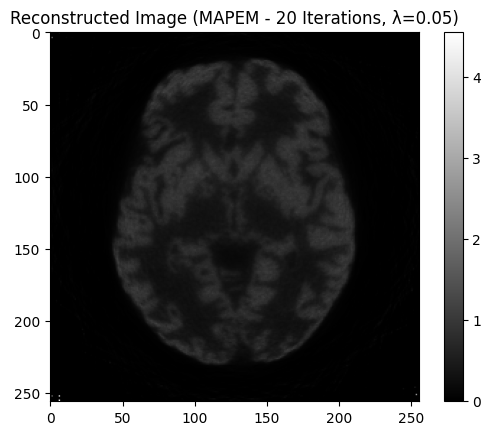

In [44]:
# Visualize the MAPEM reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f"Reconstructed Image (MAPEM - {num_iterations} Iterations, λ={lambda_reg})")
plt.colorbar()
plt.show()

### Comparison of MAPEM and MLEM

- MLEM: Focuses on maximizing likelihood (data fidelity) and can amplify noise.
- MAPEM: Balances likelihood and prior knowledge for smoother, less noisy reconstructions.

The **MAPEM (Maximum A Posteriori Expectation Maximization)** algorithm extends the **MLEM (Maximum Likelihood Expectation Maximization)** algorithm by incorporating **prior knowledge** about the image into the reconstruction process. This prior acts as a regularization term to improve image quality, reduce noise, or enforce desired properties (e.g., smoothness or sparsity).

---

**MAPEM Update Formula**
$$
x^{(k+1)} = x^{(k)} \times \frac{\text{Backproject}\left(\frac{\text{Sinogram}}{\text{Forward Project}(x^{(k)})}\right)}{\text{Backproject}(1) + \lambda \nabla R(x^{(k)})}
$$

Where:
- $x^{(k)}$: Current estimate of the reconstructed image at iteration $k$.
- $\text{Sinogram}$: Measured projection data.
- $\text{Forward Project}(x^{(k)})$: Simulated projections of the current image estimate.
- $\text{Backproject}$: Backprojection operator to redistribute corrections into image space.
- $\lambda$: Regularization parameter controlling the strength of the prior.
- $R(x^{(k)})$: Prior function (e.g., smoothness, sparsity).
- $\nabla R(x^{(k)})$: Gradient of the prior.

---

**Explanation of Each Term**

**1. Likelihood Term (MLEM Part)**
$$
\text{Backproject}\left(\frac{\text{Sinogram}}{\text{Forward Project}(x^{(k)})}\right)
$$
- **Purpose**:
  - Maximizes the likelihood of observing the measured sinogram given the reconstructed image.
- **Details**:
  - Compares the measured sinogram with the forward-projected sinogram of the current estimate.
  - The ratio $\frac{\text{Sinogram}}{\text{Forward Project}(x^{(k)})}$ calculates the correction needed for each projection.
  - This correction is then backprojected into image space to update $x^{(k)}$.

**2. Normalization Factor**
$$
\text{Backproject}(1)
$$
- **Purpose**:
  - Ensures stability and prevents divergence of the reconstruction.
- **Details**:
  - Backprojects a sinogram of ones to normalize the correction.

**3. Prior Term (Regularization)**
$$
\lambda \nabla R(x^{(k)})
$$
- **Purpose**:
  - Introduces prior knowledge to enforce certain properties in the reconstructed image.
- **Details**:
  - $R(x)$: Prior function, such as smoothness or sparsity.
  - $\nabla R(x)$: Gradient of the prior, which adjusts the update to penalize undesirable image properties (e.g., noise).
  - $\lambda$: Controls the balance between the data fidelity term and the prior.

**4. Multiplicative Update**
$$
x^{(k+1)} = x^{(k)} \times \frac{\text{Likelihood Update}}{\text{Normalization + Prior}}
$$
- **Purpose**:
  - Iteratively refines the reconstruction by correcting errors while enforcing prior constraints.
- **Details**:
  - The multiplicative update ensures non-negativity of the reconstructed image.

---

**Common Priors**
1. **Quadratic Smoothness Prior**:
   - Penalizes large differences between neighboring pixels.
   - Gradient:
     $$
     \nabla R(x) = \sum_{\text{neighbors}} (x_{i,j} - x_{\text{neighbor}})
     $$

2. **Huber Loss Prior (Edge-Preserving)**:
   - Quadratic for small differences, linear for large differences.
   - Gradient:
     $$
     \nabla R(x) =
     \begin{cases}
     x_{i,j} - x_{\text{neighbor}}, & |x_{i,j} - x_{\text{neighbor}}| \leq \delta \\
     \delta \cdot \text{sign}(x_{i,j} - x_{\text{neighbor}}), & |x_{i,j} - x_{\text{neighbor}}| > \delta
     \end{cases}
     $$

3. **Sparse Prior (L1 Regularization)**:
   - Promotes sparsity in the image.
   - Gradient:
     $$
     \nabla R(x) = \text{sign}(x)
     $$

---

**Comparison to MLEM**
- **MLEM**:
  - Maximizes likelihood (data fidelity) only.
  - Susceptible to noise amplification with more iterations.
- **MAPEM**:
  - Balances likelihood with prior knowledge.
  - Reduces noise and enforces desirable image properties, but requires careful tuning of $\lambda$.

---

**Advantages of MAPEM**
- Reduces noise and artifacts in reconstructions.
- Allows customization using domain-specific priors.
- Provides flexibility to balance data fidelity and regularization.

---

**When to Use MAPEM**
- When noise suppression is critical.
- When specific properties (e.g., smoothness or sparsity) are desired in the reconstruction.
- In scenarios where raw MLEM reconstructions amplify noise or fail to converge effectively.

Would you like a practical implementation of a specific prior in MAPEM, or a deeper analysis of its convergence properties? Let me know!

## Using Deep Learning to Make Conventional Methods Great Again

Refer to MAPEM-NET, we implement a U-net to make the MAPEM decent more smoothly and more fast.

To implement a MAPEM-Net, we can combine the MAPEM iterative process with a U-Net-based regularizer. Here's the approach:

1. Initialize the reconstructed image with a uniform or initial estimate.
2. At each iteration:
  - Perform the MLEM update.
  - Pass the current estimate through a U-Net to regularize it.
  - Update the reconstructed image using the output from the U-Net and the MAPEM formula.

### Training mode

1. Generate training data
2. Training
3. Evaluation

#### Generate training data

In [45]:
# Re-importing libraries after execution state reset
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from tqdm import tqdm

# Redefine mapem_reconstruction
def mapem_reconstruction(sinogram, num_iterations, angles, lambda_reg=0.01, delta=0.2):
    """
    MAPEM Reconstruction with an edge-preserving prior using Huber loss.

    Parameters:
        sinogram: 2D array
            Input sinogram data.
        num_iterations: int
            Number of iterations for the MAPEM algorithm.
        angles: 1D array
            Projection angles used in the sinogram acquisition.
        lambda_reg: float
            Regularization parameter controlling the strength of the prior.
        delta: float
            Threshold for the Huber loss regularization.

    Returns:
        reconstructed_image: 2D array
            The reconstructed image.
    """
    # Initialize the reconstructed image with uniform values
    reconstructed_image = np.ones((sinogram.shape[0], sinogram.shape[0]))

    # Compute the backprojection of ones for normalization
    ones_sinogram = np.ones_like(sinogram)
    normalization_factor = iradon(ones_sinogram, theta=angles, circle=True, filter_name=None)

    # Define the Huber loss gradient for edge-preserving regularization
    def huber_gradient(image, delta):
        grad = np.zeros_like(image)

        # Compute vertical differences
        vertical_diff = image[:-1, :] - image[1:, :]
        grad[:-1, :] += np.where(np.abs(vertical_diff) <= delta, vertical_diff, delta * np.sign(vertical_diff))
        grad[1:, :] -= np.where(np.abs(vertical_diff) <= delta, vertical_diff, delta * np.sign(vertical_diff))

        # Compute horizontal differences
        horizontal_diff = image[:, :-1] - image[:, 1:]
        grad[:, :-1] += np.where(np.abs(horizontal_diff) <= delta, horizontal_diff, delta * np.sign(horizontal_diff))
        grad[:, 1:] -= np.where(np.abs(horizontal_diff) <= delta, horizontal_diff, delta * np.sign(horizontal_diff))

        return grad

    data_loop = []
    # Iterative MAPEM updates
    for _ in range(num_iterations):
        # Compute the forward projection of the current estimate
        data_loop.append(reconstructed_image)
        forward_projection = radon(reconstructed_image, theta=angles, circle=True)

        # Compute the correction factor
        correction_factor = np.divide(sinogram, forward_projection,
                                       out=np.zeros_like(sinogram),
                                       where=forward_projection != 0)

        # Backproject the correction factor
        backprojected_correction = iradon(correction_factor, theta=angles, circle=True, filter_name=None)

        # Compute the regularization term
        reg_term = 1 - lambda_reg * huber_gradient(reconstructed_image, delta)

        # Update the reconstructed image
        reconstructed_image *= backprojected_correction / (normalization_factor + reg_term)

        # Ensure non-negativity
        reconstructed_image = np.maximum(reconstructed_image, 0)

    return reconstructed_image, data_loop

# Redefine generate_training_data_mapem
def generate_training_data_mapem(phantom, angles, iterations, noise_levels, lambda_reg=0.01, delta=0.2):
    """
    Generate noisy MAPEM outputs as training data.

    Parameters:
        phantom: 2D array
            Clean ground truth image (phantom).
        angles: 1D array
            Projection angles for sinogram generation.
        iterations_list: list of int
            List of iteration counts for MAPEM.
        noise_levels: list of float
            List of Gaussian noise levels to add to the sinograms.
        lambda_reg: float
            Regularization strength for MAPEM.
        delta: float
            Huber threshold for edge-preserving regularization.

    Returns:
        training_data: list of tuples
            List of (noisy_reconstruction, ground_truth) pairs.
    """
    # Generate clean sinogram
    sinogram = radon(phantom, theta=angles, circle=True)

    training_data = []
    for noise_level in noise_levels:
        # Add noise to the sinogram
        noisy_sinogram = sinogram + np.random.normal(0, noise_level, sinogram.shape)
        print(f'generating {noise_level}')
        # Perform MAPEM reconstruction
        noisy_reconstruction, data_loop = mapem_reconstruction(
            noisy_sinogram, iterations, angles, lambda_reg, delta
        )
        training_data.append((noisy_reconstruction, phantom))

        for item in data_loop:
            # Append noisy reconstruction and ground truth
            training_data.append((item, phantom))


    return training_data

generating 1


/usr/local/lib/python3.10/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


generating 5
generating 10
generating 15
generating 20


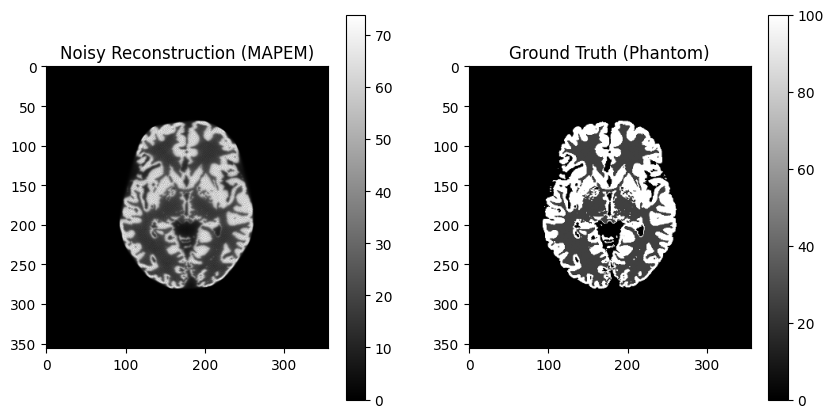

In [ ]:
# Example Usage
phantom = data['aphantom']
phantom = np.pad(phantom, ((50, 50), (50, 50)), mode='constant')  # Pad to make it larger
angles = np.linspace(0, 180, 180, endpoint=False)  # Define projection angles
iterations = 50
noise_levels = [1, 5, 10, 15, 20]        # Different noise levels

# Generate training data using MAPEM
training_data_mapem = generate_training_data_mapem(phantom, angles, iterations, noise_levels)

# Visualize one example
noisy_reconstruction_mapem, ground_truth_mapem = training_data_mapem[0]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(noisy_reconstruction_mapem, cmap='gray')
plt.title("Noisy Reconstruction (MAPEM)")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(ground_truth_mapem, cmap='gray')
plt.title("Ground Truth (Phantom)")
plt.colorbar()
plt.show()

In [ ]:
# save training data
import pickle
with open("/content/drive/MyDrive/PET/training_data.pkl", "wb") as file:
    pickle.dump(training_data_mapem, file)

In [ ]:
# load training data
with open("/content/drive/MyDrive/PET/training_data.pkl", "rb") as file:
    training_data_mapem = pickle.load(file)

print("Loaded", len(training_data_mapem))


Loaded 255


#### Define U-Net

In [46]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.bottleneck = self.conv_block(features[-1], features[-1] * 2)

        # Downsampling layers
        for feature in features:
            self.downs.append(self.conv_block(in_channels, feature))
            in_channels = feature

        # Upsampling layers
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(self.conv_block(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                # Handle mismatched dimensions during concatenation
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            x = torch.cat((x, skip_connection), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

    @staticmethod
    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

#### Train

In [ ]:
from torch.utils.data import DataLoader, Dataset

# Custom dataset
class ReconstructionDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        noisy_reconstruction, ground_truth = self.data[idx]
        return (
            torch.tensor(noisy_reconstruction, dtype=torch.float32).unsqueeze(0),
            torch.tensor(ground_truth, dtype=torch.float32).unsqueeze(0),
        )

In [ ]:
len(training_data_mapem)

255

In [ ]:
from torch.utils.data import random_split

# Split ratios
train_ratio = 0.8
test_ratio = 0.2

# Total number of samples
total_samples = len(training_data_mapem)

# Calculate sizes for training and test sets
train_size = int(train_ratio * total_samples)
test_size = total_samples - train_size

# Split the dataset
train_data, test_data = random_split(training_data_mapem, [train_size, test_size])

# Create DataLoaders for training and testing
batch_size = 4
train_dataloader = DataLoader(ReconstructionDataset(train_data), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(ReconstructionDataset(test_data), batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_data)}, Test samples: {len(test_data)}")

Training samples: 204, Test samples: 51


In [ ]:
# Define loss function and optimizer
unet = UNet()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-2)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = unet.to(device)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Early stopping to terminate training when validation loss stops improving.

        Parameters:
            patience: int
                Number of epochs to wait after last improvement.
            min_delta: float
                Minimum change in the monitored metric to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=1e-4)

# Training loop with early stopping
num_epochs = 50
for epoch in range(num_epochs):
    unet.train()
    train_loss = 0
    for noisy_reconstruction, ground_truth in train_dataloader:
        noisy_reconstruction = noisy_reconstruction.to(device)
        ground_truth = ground_truth.to(device)

        # Forward pass
        output = unet(noisy_reconstruction)

        # Compute loss
        loss = loss_fn(output, ground_truth)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loss (use a validation dataloader)
    unet.eval()
    val_loss = 0
    with torch.no_grad():
        for noisy_reconstruction, ground_truth in test_dataloader:
            noisy_reconstruction = noisy_reconstruction.to(device)
            ground_truth = ground_truth.to(device)

            output = unet(noisy_reconstruction)
            val_loss += loss_fn(output, ground_truth).item()

    # Average validation loss
    val_loss /= len(test_dataloader)

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_dataloader):.4f}, Val Loss: {val_loss:.4f}")

    # Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Training terminated.")
        break

Epoch 1, Train Loss: 535193611381370471317504.0000, Val Loss: 1097.9345
Epoch 2, Train Loss: 1900787051787562390650880.0000, Val Loss: 1099.1459
Epoch 3, Train Loss: 79369803091154544921411584.0000, Val Loss: 1101.8627
Epoch 4, Train Loss: 1101.9199, Val Loss: 1101.9338
Epoch 5, Train Loss: 1101.9343, Val Loss: 1101.9343
Epoch 6, Train Loss: 1101.9343, Val Loss: 1101.9343
Early stopping triggered. Training terminated.


In [ ]:
import torch

# Specify the path to save the model
model_save_path = "/content/drive/MyDrive/PET/unet_model_2.pth"

# Save the model's state_dict
torch.save(unet.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/PET/unet_model_2.pth


In [47]:
# MAPEM-Net Reconstruction
def mapem_net_reconstruction(sinogram, num_iterations, angles, unet, device, lambda_reg=0.01):
    """
    MAPEM-Net Reconstruction with U-Net regularization.
    """
    # Initialize the reconstructed image with a uniform value
    reconstructed_image = np.ones((sinogram.shape[0], sinogram.shape[0]))

    # Convert to PyTorch tensor
    reconstructed_image_tensor = torch.tensor(reconstructed_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    image_loop = []
    # Iterative MAPEM-Net updates
    for _ in range(num_iterations):
        # Compute the forward projection of the current estimate
        image_loop.append(reconstructed_image)
        forward_projection = radon(reconstructed_image, theta=angles, circle=True)

        # Compute the correction factor
        correction_factor = np.divide(sinogram, forward_projection,
                                       out=np.zeros_like(sinogram),
                                       where=forward_projection != 0)

        # Backproject the correction factor
        backprojection = iradon(correction_factor, theta=angles, circle=True, filter_name=None)

        # Add the backprojected image
        reconstructed_image *= backprojection

        # Pass the reconstructed image through the U-Net
        reconstructed_image_tensor = torch.tensor(reconstructed_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            reg_image = unet(reconstructed_image_tensor).squeeze().cpu().numpy()

        # Update the reconstructed image with regularization
        reconstructed_image = reconstructed_image * (1 - lambda_reg) + reg_image * lambda_reg

    return reconstructed_image, image_loop

- For not-trained result

/usr/local/lib/python3.10/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


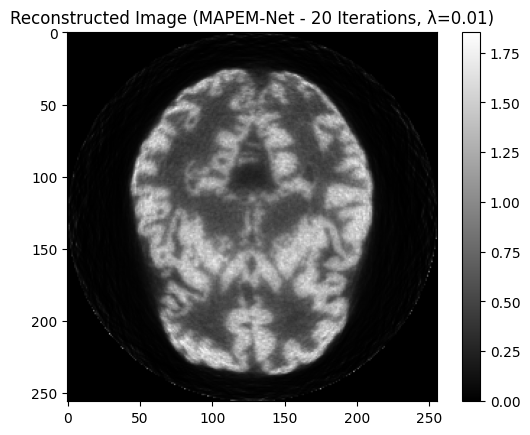

In [48]:
# Instantiate and initialize the U-Net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet().to(device)

# Set parameters for MAPEM-Net reconstruction
num_iterations = 20
lambda_reg = 0.01

# Perform MAPEM-Net reconstruction
reconstructed_image, image_loop = mapem_net_reconstruction(sinogram_exp, num_iterations, angles, unet, device, lambda_reg)

# Visualize the MAPEM-Net reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f"Reconstructed Image (MAPEM-Net - {num_iterations} Iterations, λ={lambda_reg})")
plt.colorbar()
plt.show()

- For trained version

<ipython-input-49-8c225b542039>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))


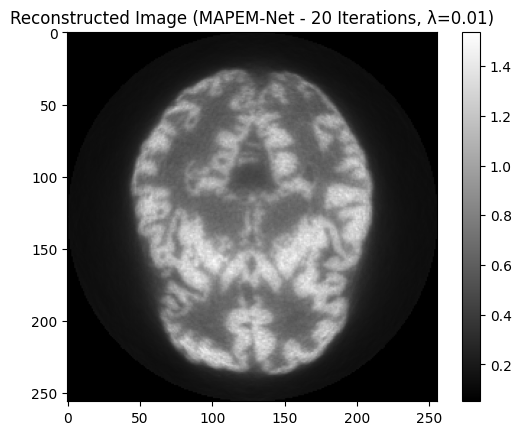

In [49]:
model_save_path = "/content/drive/MyDrive/PET/unet_model.pth"
# Instantiate and initialize the U-Net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet().to(device)

# Load the state_dict into the model
if torch.cuda.is_available():
    unet.load_state_dict(torch.load(model_save_path))
else:
    unet.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode
unet.eval()
# Set parameters for MAPEM-Net reconstruction
num_iterations = 20
lambda_reg = 0.01

# Perform MAPEM-Net reconstruction
reconstructed_image, image_loop = mapem_net_reconstruction(sinogram_exp, num_iterations, angles, unet, device, lambda_reg)

# Visualize the MAPEM-Net reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f"Reconstructed Image (MAPEM-Net - {num_iterations} Iterations, λ={lambda_reg})")
plt.colorbar()
plt.show()

In [50]:
def run_mapem_net_reconstruction(sinogram, num_iterations, angles, lambda_reg=0.01, pretrained=True, model_save_path="/content/drive/MyDrive/PET/unet_model.pth"):
    # Instantiate and initialize the U-Net
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    unet = UNet().to(device)

    if pretrained:
      # Load the state_dict into the model
      if torch.cuda.is_available():
          unet.load_state_dict(torch.load(model_save_path))
      else:
          unet.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))

      # Set the model to evaluation mode
      unet.eval()

    # Perform MAPEM-Net reconstruction
    reconstructed_image, image_loop = mapem_net_reconstruction(sinogram, num_iterations, angles, unet, device, lambda_reg)

    return reconstructed_image, image_loop

## Experiments

Experiment pipeline:

Reconstruct the image according to defferent level of noise-data, generate from different methods.

To evaluate the method MLEM, MAPEM, and MAPEM-Net, with the factor of PSNR, SSIM, MSE, MAE, CRC-STD, and NRMSE. More over we draw the curve of the relative method to see the converge of the methods

### Simulate different noise level image

Using previously implemented function `simulate_2d_pet_with_custom_radon`

In [51]:
ground_truth = data['aphantom']
ground_truth.shape

(256, 256)

In [106]:
def generate_evaluate_target(phantom, noise_level=5):
    # Example Usage
    angles = np.linspace(0, 180, 180, endpoint=False)  # 180 evenly spaced angles
    noisy_sinogram_custom = simulate_2d_pet(phantom, angles=angles, noise_level=noise_level) # , noise_type="poisson")
    output_size = phantom.shape[0]
    return noisy_sinogram_custom, angles, output_size

### Implement the evaluation

In [53]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import numpy as np

In [55]:
def compute_crc_std(reconstructed_image, true_image, contrast_mask, background_mask):
    """
    Compute CRC and STD for a reconstructed image.

    Parameters:
        reconstructed_image: 2D array
            Reconstructed image.
        true_image: 2D array
            Ground truth image (phantom).
        contrast_mask: 2D boolean array
            Mask defining the contrast region.
        background_mask: 2D boolean array
            Mask defining the background region.

    Returns:
        crc: float
            Contrast Recovery Coefficient.
        std: float
            Standard Deviation in the background region.
    """
    # Mean intensities
    mu_contrast = np.mean(reconstructed_image[contrast_mask])
    mu_background = np.mean(reconstructed_image[background_mask])
    mu_true_contrast = np.mean(true_image[contrast_mask])
    mu_true_background = np.mean(true_image[background_mask])

    # CRC calculation
    crc = (mu_contrast - mu_background) / (mu_true_contrast - mu_true_background)

    # STD calculation
    background_pixels = reconstructed_image[background_mask]
    std = np.std(background_pixels)

    return crc, std

In [56]:
def compute_nrmse(reconstructed_image, ground_truth, normalization='range'):
    """
    Compute the Normalized Root Mean Squared Error (NRMSE).

    Parameters:
        reconstructed_image: 2D array
            Reconstructed image.
        ground_truth: 2D array
            Ground truth image (phantom).
        normalization: str, optional
            Method of normalization ('range' or 'mean').
            - 'range': Normalized by the range of ground truth values.
            - 'mean': Normalized by the mean of ground truth values.

    Returns:
        nrmse: float
            The computed NRMSE value.
    """
    mse = np.mean((reconstructed_image - ground_truth) ** 2)
    rmse = np.sqrt(mse)

    if normalization == 'range':
        norm_factor = np.max(ground_truth) - np.min(ground_truth)
    elif normalization == 'mean':
        norm_factor = np.mean(ground_truth)
    else:
        raise ValueError("Invalid normalization method. Choose 'range' or 'mean'.")

    nrmse = rmse / norm_factor
    return nrmse

#### Calculate metrics function

In [57]:
def cal_all_in_one(ground_truth, reconstructed_image, reconstructed_image_loop):
    # Define masks for contrast and background regions
    contrast_mask = (ground_truth > 0.5)  # Example: High-intensity region in the phantom
    background_mask = (ground_truth < 0.1)  # Example: Low-intensity region in the phantom

    # Compute CRC and STD for different iterations
    iterations = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    crc_values = []
    std_values = []
    nrmse_range_values = []
    nrmse_mean_values = []
    psnr_values = []
    ssim_values = []
    mse_values = []
    mae_values = []

    for num_iter in iterations:
        if num_iter > len(reconstructed_image_loop):
            break

        iter_image = reconstructed_image_loop[num_iter-1]

        # Contrast Recovery Coefficient
        crc, std = compute_crc_std(iter_image, ground_truth, contrast_mask, background_mask)

        # Normalized Root Mean Squared Error (NRMSE)
        nrmse_range = compute_nrmse(iter_image, ground_truth, normalization='range')

        # Normalized Root Mean Squared Error (NRMSE)
        nrmse_mean = compute_nrmse(iter_image, ground_truth, normalization='mean')

        # Peak Signal-to-Noise Ratio
        psnr_value = psnr(ground_truth, iter_image, data_range=ground_truth.max() - ground_truth.min())

        # Structural Similarity Index Measure
        ssim_value = ssim(ground_truth, iter_image, data_range=ground_truth.max() - ground_truth.min())

        # Mean Squared Error
        mse_value = mean_squared_error(ground_truth.flatten(), iter_image.flatten())

        # Mean Absolute Error
        mae_value = np.mean(np.abs(ground_truth - iter_image))

        crc_values.append(crc)
        std_values.append(std)
        nrmse_range_values.append(nrmse_range)
        nrmse_mean_values.append(nrmse_mean)
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)
        mse_values.append(mse_value)
        mae_values.append(mae_value)

    crc, std = compute_crc_std(reconstructed_image, ground_truth, contrast_mask, background_mask)

    # Normalized Root Mean Squared Error (NRMSE)
    nrmse_range = compute_nrmse(reconstructed_image, ground_truth, normalization='range')

    # Normalized Root Mean Squared Error (NRMSE)
    nrmse_mean = compute_nrmse(reconstructed_image, ground_truth, normalization='mean')

    # Peak Signal-to-Noise Ratio
    psnr_value = psnr(ground_truth, reconstructed_image, data_range=ground_truth.max() - ground_truth.min())

    # Structural Similarity Index Measure
    ssim_value = ssim(ground_truth, reconstructed_image, data_range=ground_truth.max() - ground_truth.min())

    # Mean Squared Error
    mse_value = mean_squared_error(ground_truth.flatten(), reconstructed_image.flatten())

    # Mean Absolute Error
    mae_value = np.mean(np.abs(ground_truth - reconstructed_image))

    crc_values.append(crc)
    std_values.append(std)
    nrmse_range_values.append(nrmse_range)
    nrmse_mean_values.append(nrmse_mean)
    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)
    mse_values.append(mse_value)
    mae_values.append(mae_value)


    return {
        "crc_values": crc_values,
        "std_values": std_values,
        "nrmse_range_values": nrmse_range_values,
        "nrmse_mean_values": nrmse_mean_values,
        "psnr_values": psnr_values,
        "ssim_values": ssim_values,
        "mse_values": mse_values,
        "mae_values": mae_values
    }

### Run Evaluation

We will evaluate the method through different level of noise added sinogram.

In [107]:
noisy_sinogram_custom_exp, angles_exp, output_size_exp = generate_evaluate_target(ground_truth, noise_level=20)

In [108]:
noisy_sinogram_custom_exp.shape

(256, 180)

In [109]:
num_iterations_exp = 50

# Perform MLEM reconstruction
reconstructed_image_mlem_pack, image_loop_mlem_pack = mlem_reconstruction(
    sinogram=noisy_sinogram_custom_exp,
    num_iterations=num_iterations_exp,
    angles=angles_exp
)
reconstructed_image_mlem, image_loop_mlem = mlem(
    sinogram=noisy_sinogram_custom_exp,
    angles=angles_exp,
    num_iterations=num_iterations_exp,
    output_size=output_size_exp
)
print("MLEM Done!")

# Perform MAPEM reconstruction
reconstructed_image_mapem_pack, image_loop_mapem_pack = mapem_reconstruction(
    sinogram=noisy_sinogram_custom_exp,
    num_iterations=num_iterations_exp,
    angles=angles_exp,
    lambda_reg=0.1
)
reconstructed_image_mapem, image_loop_mapem = mapem(
    sinogram=noisy_sinogram_custom_exp,
    angles=angles_exp,
    num_iterations=num_iterations_exp,
    output_size=output_size_exp,
    lambda_reg=0.1
)
print("MAPEM Done!")

# Perform MAPEM-NET reconstruction
reconstructed_image_mapem_net, image_loop_mapem_net = run_mapem_net_reconstruction(
    sinogram=noisy_sinogram_custom_exp,
    angles=angles_exp,
    num_iterations=num_iterations_exp,
    lambda_reg=0.01,
    pretrained=False
)
reconstructed_image_mapem_net_pretrained, image_loop_mapem_net_pretrained = run_mapem_net_reconstruction(
    sinogram=noisy_sinogram_custom_exp,
    angles=angles_exp,
    num_iterations=num_iterations_exp,
    lambda_reg=0.01,
    pretrained=True
)
print("MAPEM-NET Done!")

/usr/local/lib/python3.10/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


MLEM Done!
MAPEM Done!


<ipython-input-50-37b88eac5f4d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))


MAPEM-NET Done!


### Evalue

In [110]:
mlem_metrics_pack = cal_all_in_one(
    ground_truth=data['aphantom'],
    reconstructed_image=reconstructed_image_mlem_pack,
    reconstructed_image_loop=image_loop_mlem_pack
)
mlem_metrics = cal_all_in_one(
    ground_truth=data['aphantom'],
    reconstructed_image=reconstructed_image_mlem,
    reconstructed_image_loop=image_loop_mlem
)
print("MLEM Done!")

mapem_metrics_pack = cal_all_in_one(
    ground_truth=data['aphantom'],
    reconstructed_image=reconstructed_image_mapem_pack,
    reconstructed_image_loop=image_loop_mlem_pack
)
mapem_metrics = cal_all_in_one(
    ground_truth=data['aphantom'],
    reconstructed_image=reconstructed_image_mapem,
    reconstructed_image_loop=image_loop_mapem
)
print("MAPEM Done!")

mapem_net_metrics = cal_all_in_one(
    ground_truth=data['aphantom'],
    reconstructed_image=reconstructed_image_mapem_net,
    reconstructed_image_loop=image_loop_mapem_net
)
mapem_net_metrics_pretrain = cal_all_in_one(
    ground_truth=data['aphantom'],
    reconstructed_image=reconstructed_image_mapem_net_pretrained,
    reconstructed_image_loop=image_loop_mapem_net_pretrained
)
print("MAPEM-NET Done!")

MLEM Done!
MAPEM Done!
MAPEM-NET Done!


#### Comparation
- Final result
- Interative result

In [111]:
def get_idx_result(dict_of_list, idx):
    return_dict = {}
    for k, v in dict_of_list.items():
        return_dict[k.replace('_values', '').upper()] = v[idx]
    return return_dict

In [112]:
mlem_pack_metrics_final = get_idx_result(mlem_metrics_pack, -1)
mlem_metrics_final = get_idx_result(mlem_metrics, -1)
mapem_pack_metrics_final = get_idx_result(mapem_metrics_pack, -1)
mapem_metrics_final = get_idx_result(mapem_metrics, -1)
mapem_net_metrics_final = get_idx_result(mapem_net_metrics, -1)
mapem_net_pretrained_metrics_final = get_idx_result(mapem_net_metrics_pretrain, -1)

In [113]:
import pandas as pd
metrics_df = pd.DataFrame(
    [mlem_pack_metrics_final,mlem_metrics_final,mapem_pack_metrics_final,mapem_metrics_final,mapem_net_metrics_final,mapem_net_pretrained_metrics_final],
    index=["MLEM_pack", "MLEM", "MAPEM_pack", "MAPEM", "MAPEM_NET", "MAPEM_NET_pretrained"]
)
metrics_df
# import ace_tools as tools; tools.display_dataframe_to_user(name="Reconstruction Metrics Comparison", dataframe=metrics_df)

CRC       STD  NRMSE_RANGE  NRMSE_MEAN      PSNR  \
MLEM_pack             0.006519  0.262445     0.458083    1.834415  6.781107   
MLEM                  0.008170  0.263632     0.456971    1.829959  6.802230   
MAPEM_pack            0.004066  0.219062     0.459127    1.838593  6.761344   
MAPEM                 0.008135  0.277998     0.456990    1.830034  6.801873   
MAPEM_NET             0.010126  0.398250     0.456563    1.828324  6.809993   
MAPEM_NET_pretrained  0.009081  0.242850     0.456538    1.828227  6.810453   

                          SSIM          MSE        MAE  
MLEM_pack             0.517033  2098.404852  24.829899  
MLEM                  0.520990  2088.223448  24.780971  
MAPEM_pack            0.519926  2107.975617  24.883147  
MAPEM                 0.520849  2088.395202  24.781660  
MAPEM_NET             0.510905  2084.494039  24.751830  
MAPEM_NET_pretrained  0.505103  2084.273574  24.794122

In [114]:
import pandas as pd
metrics_df = pd.DataFrame(
    [mlem_pack_metrics_final,mapem_pack_metrics_final,mapem_net_metrics_final,mapem_net_pretrained_metrics_final],
    index=["MLEM", "MAPEM", "MAPEM_NET", "MAPEM_NET_pretrained"]
)
metrics_df

CRC       STD  NRMSE_RANGE  NRMSE_MEAN      PSNR  \
MLEM                  0.006519  0.262445     0.458083    1.834415  6.781107   
MAPEM                 0.004066  0.219062     0.459127    1.838593  6.761344   
MAPEM_NET             0.010126  0.398250     0.456563    1.828324  6.809993   
MAPEM_NET_pretrained  0.009081  0.242850     0.456538    1.828227  6.810453   

                          SSIM          MSE        MAE  
MLEM                  0.517033  2098.404852  24.829899  
MAPEM                 0.519926  2107.975617  24.883147  
MAPEM_NET             0.510905  2084.494039  24.751830  
MAPEM_NET_pretrained  0.505103  2084.273574  24.794122

##### Plot Part

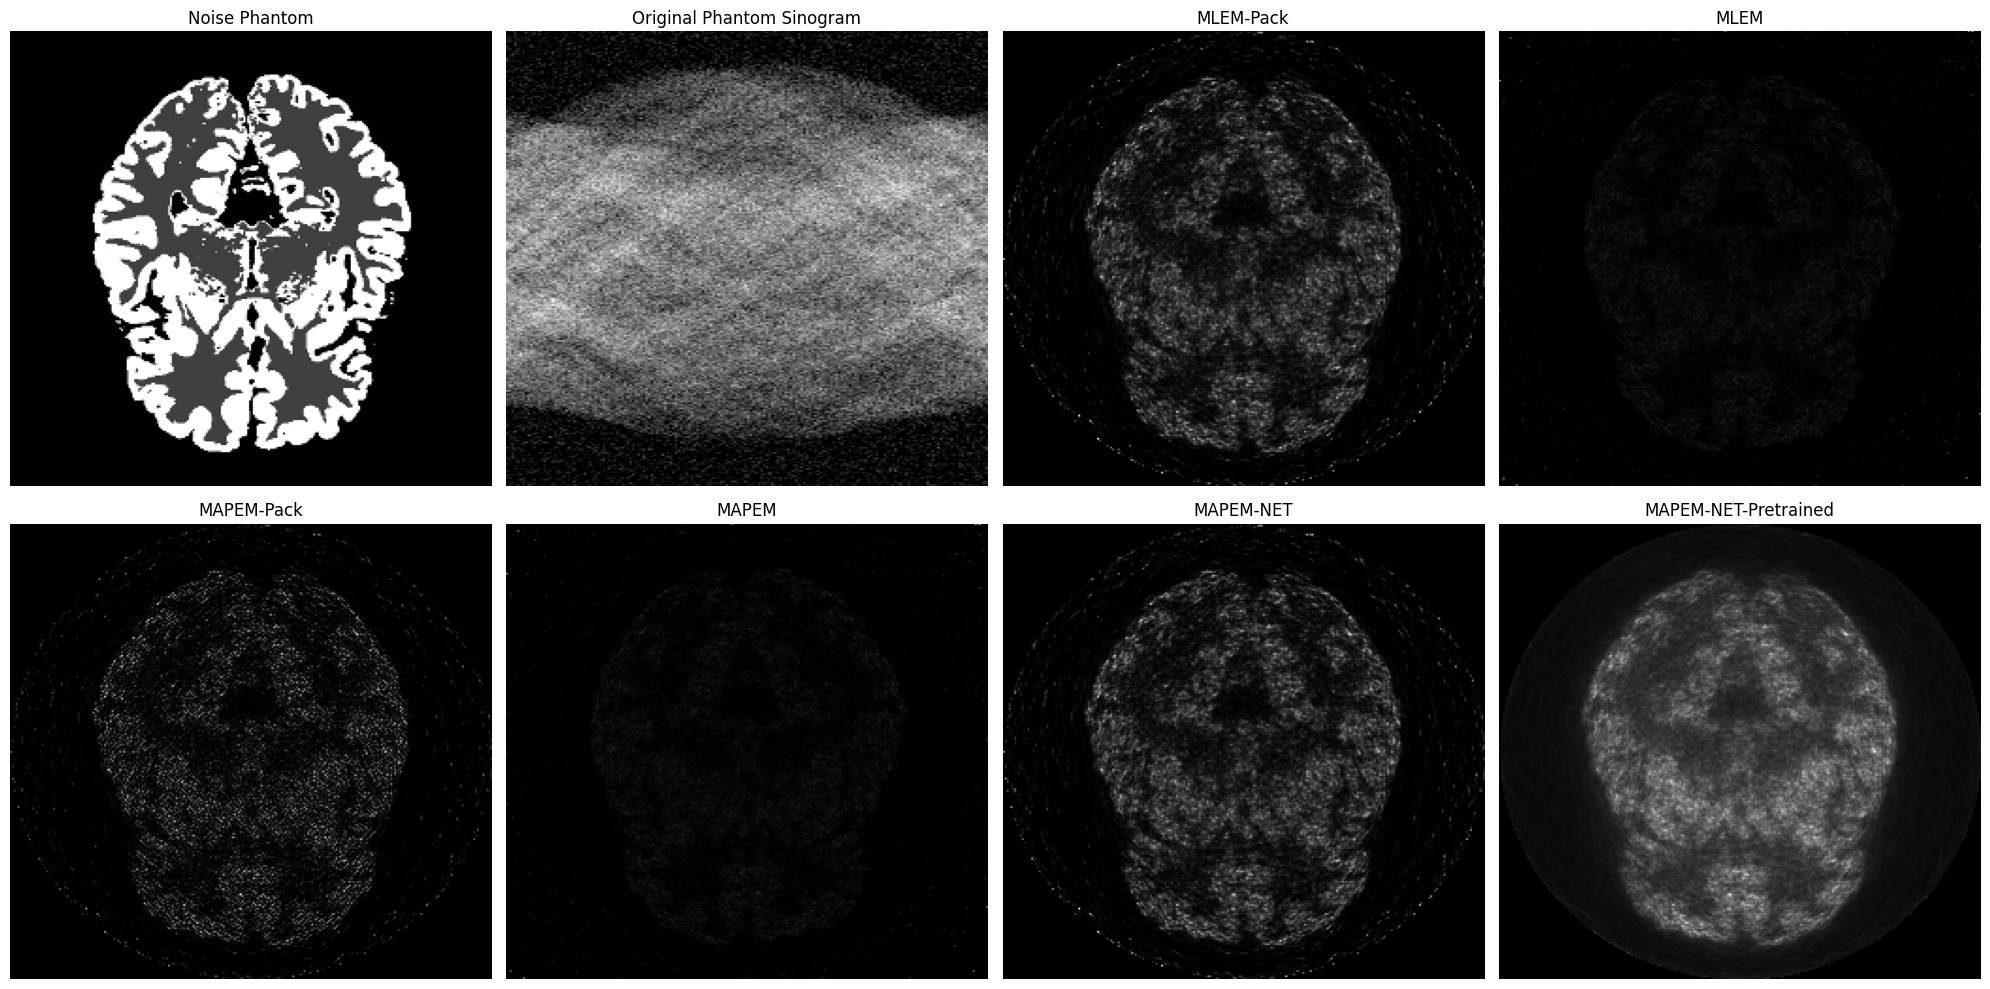

In [115]:
# Visualization comparison of all methods
methods = {
    "Noise Phantom": rotate(ground_truth, 180, reshape=False),
    "Original Phantom Sinogram": noisy_sinogram_custom_exp,
    "MLEM-Pack": reconstructed_image_mlem_pack,
    "MLEM": rotate(reconstructed_image_mlem, 180, reshape=False),
    "MAPEM-Pack": reconstructed_image_mapem_pack,
    "MAPEM": rotate(reconstructed_image_mapem, 180, reshape=False),
    "MAPEM-NET": reconstructed_image_mapem_net,
    "MAPEM-NET-Pretrained": reconstructed_image_mapem_net_pretrained,
}

# Create a figure to display the images
plt.figure(figsize=(20, 10))
for idx, (title, image) in enumerate(methods.items(), 1):
    plt.subplot(2, 4, idx)
    plt.imshow(image, aspect='auto', cmap='gray')
    plt.title(title)
    plt.axis('off')
    # plt.colorbar()

plt.tight_layout()
plt.show()

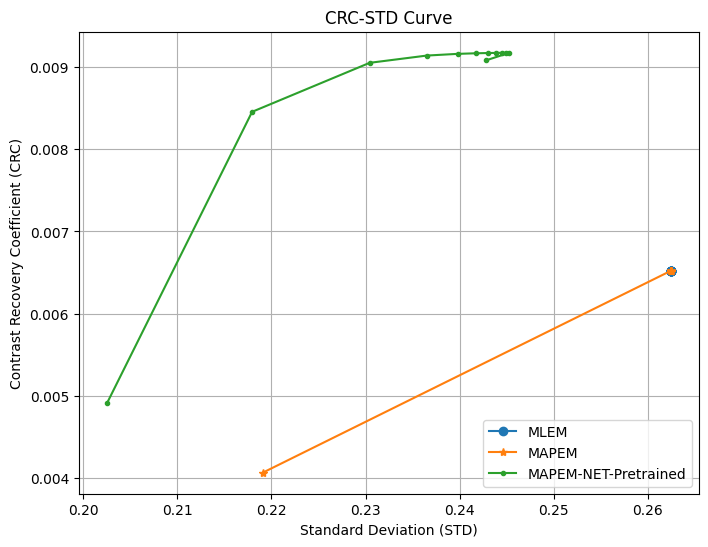

In [118]:
plt.figure(figsize=(8, 6))

plt.plot(mlem_metrics_pack["std_values"], mlem_metrics_pack["crc_values"], marker="o", label="MLEM")
# plt.plot(mlem_metrics["std_values"], mlem_metrics["crc_values"], marker="o", label="MLEM")
plt.plot(mapem_metrics_pack["std_values"], mapem_metrics_pack["crc_values"], marker="*", label="MAPEM")
# plt.plot(mapem_metrics["std_values"], mapem_metrics["crc_values"], marker="*", label="MAPEM")
# plt.plot(mapem_net_metrics["std_values"], mapem_net_metrics["crc_values"], marker="+", label="MAPEM-NET")
plt.plot(mapem_net_metrics_pretrain["std_values"], mapem_net_metrics_pretrain["crc_values"], marker=".", label="MAPEM-NET-Pretrained")

plt.xlabel("Standard Deviation (STD)")
plt.ylabel("Contrast Recovery Coefficient (CRC)")
plt.title(f"CRC-STD Curve")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Plot CRC-STD curve
import matplotlib.pyplot as plt

def plot_CRC_STD_curve(std_values, crc_values, method):
    plt.figure(figsize=(8, 6))
    plt.plot(std_values, crc_values, marker='o', label=method)
    plt.xlabel("Standard Deviation (STD)")
    plt.ylabel("Contrast Recovery Coefficient (CRC)")
    plt.title(f"{method} CRC-STD Curve")
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
def plot_one(image, methods, lambda_reg=None):
    # Visualize the reconstructed image
    plt.imshow(image, cmap='gray')
    plt.title(f"Reconstructed Image ({methods} - 50 Iterations, λ={lambda_reg})")
    plt.colorbar()
    plt.show()

In [92]:
def plot_50(image_loop):
  # Plot the reconstructed images in a grid
  fig, axes = plt.subplots(5, 10, figsize=(30, 15))
  axes = axes.flatten()

  for i, ax in enumerate(axes):
      ax.imshow(image_loop[i], cmap='gray')
      ax.set_title(f"Iteration {i+1}")
      ax.axis('off')

  plt.tight_layout()
  plt.show()

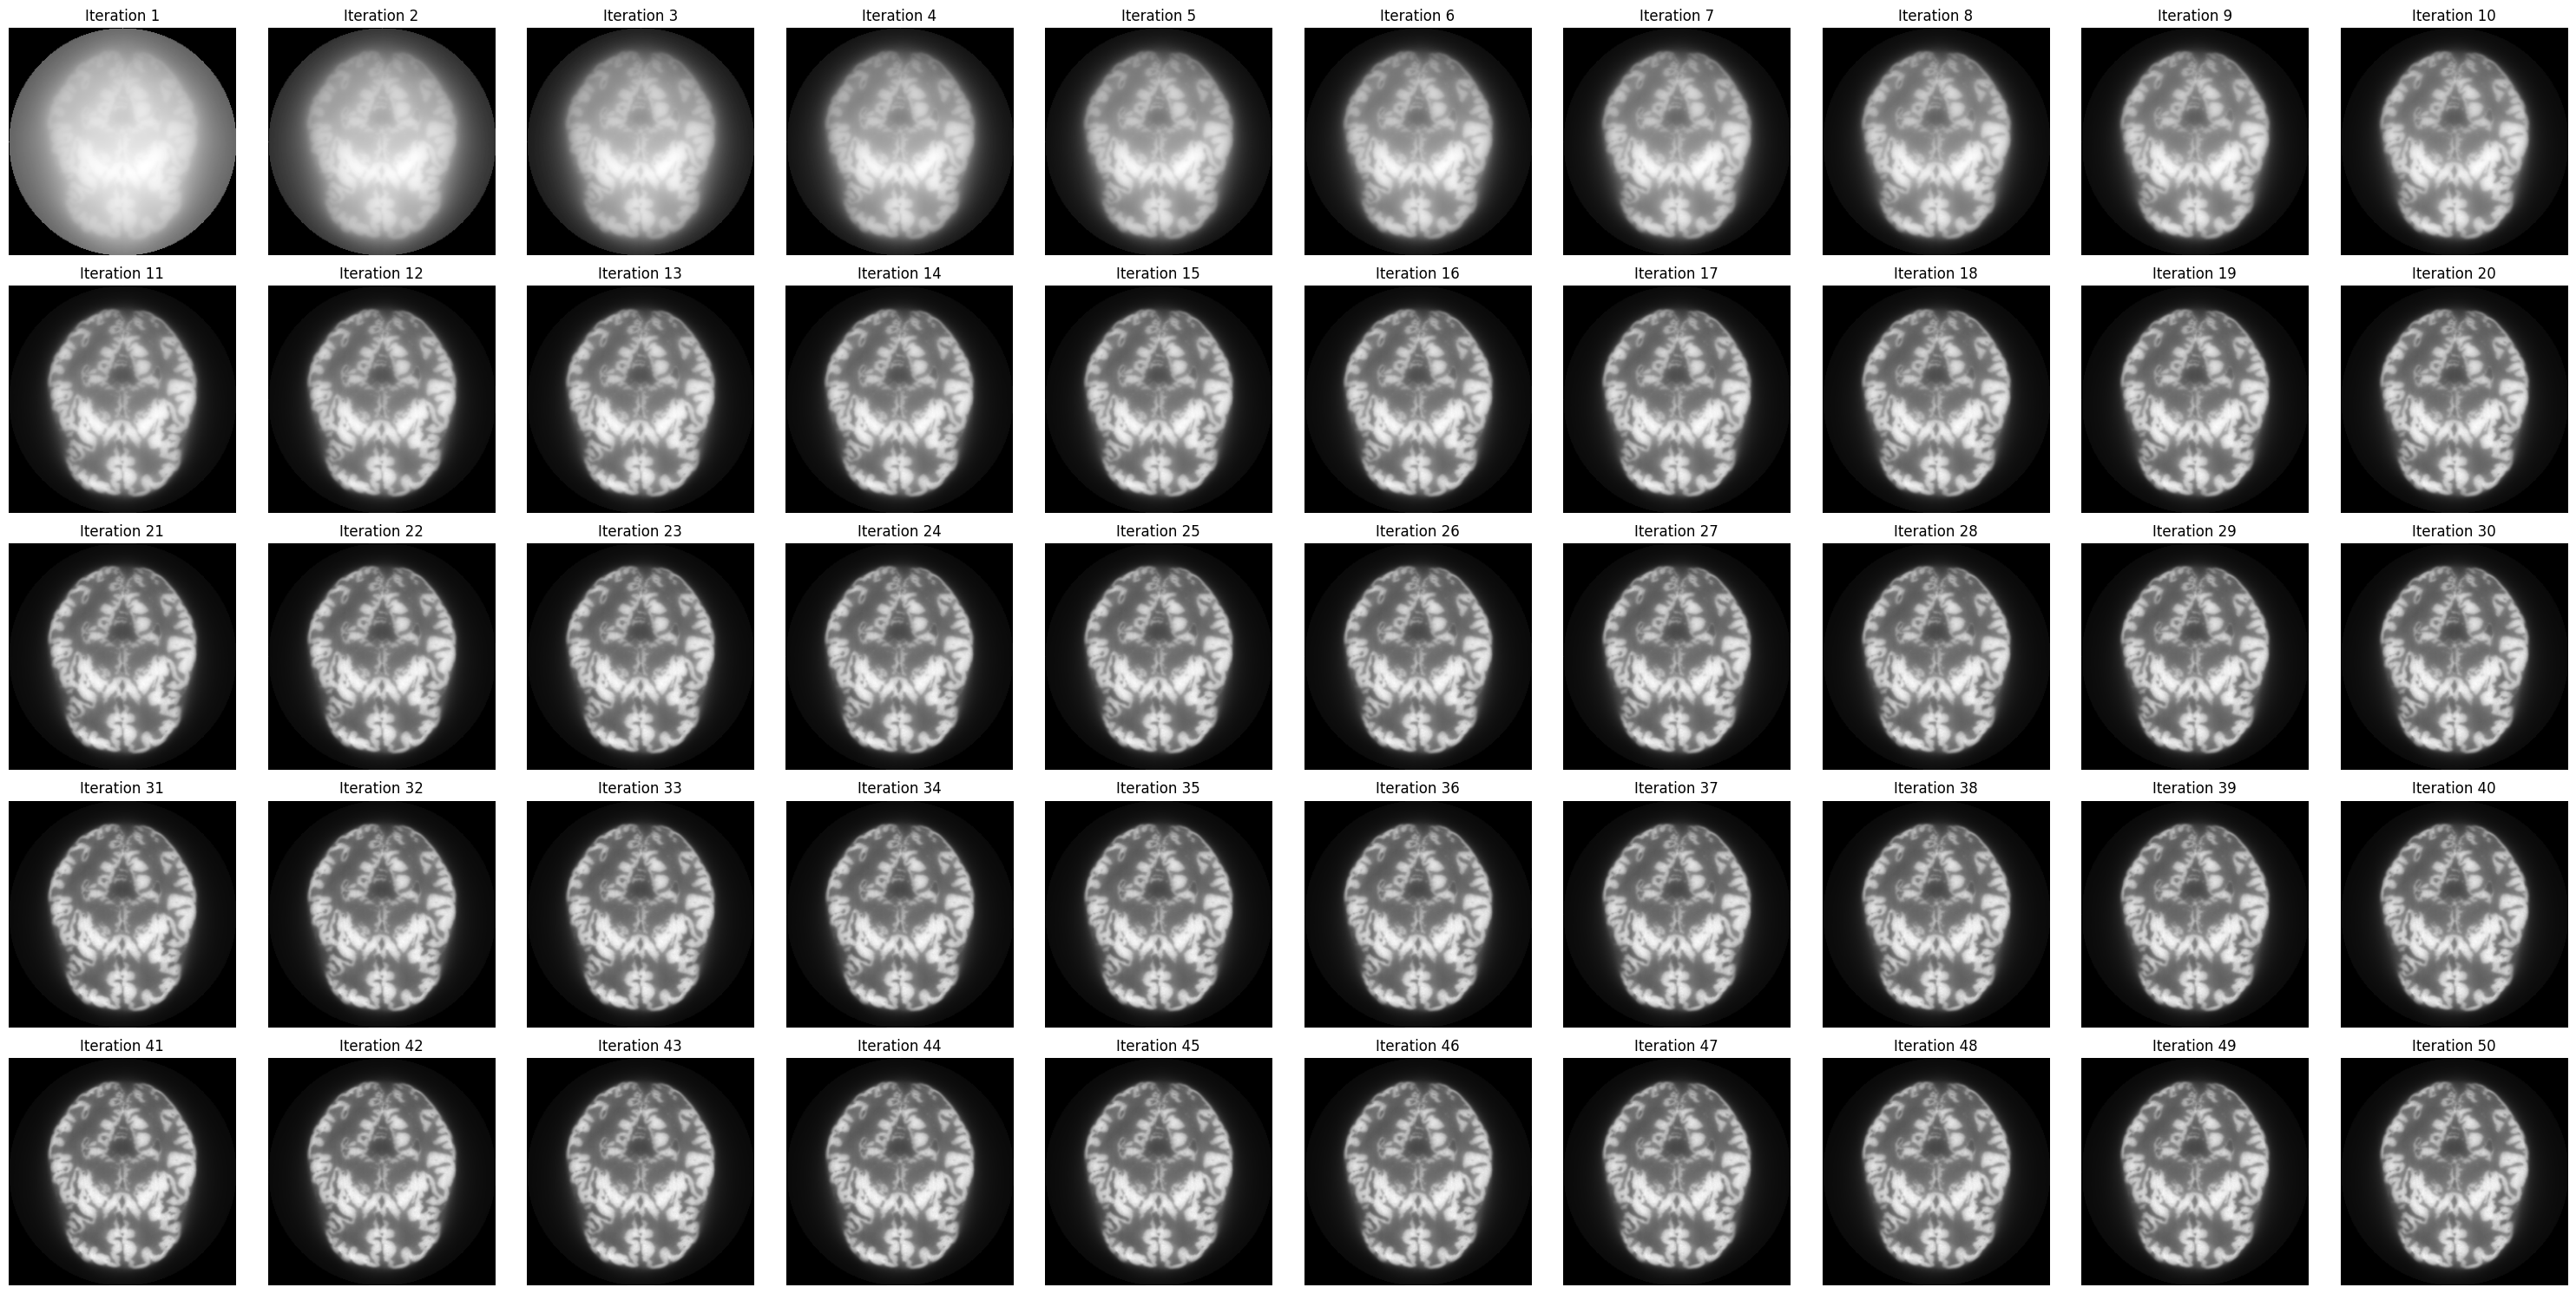

In [93]:
plot_50(image_loop_mapem_net_pretrained)

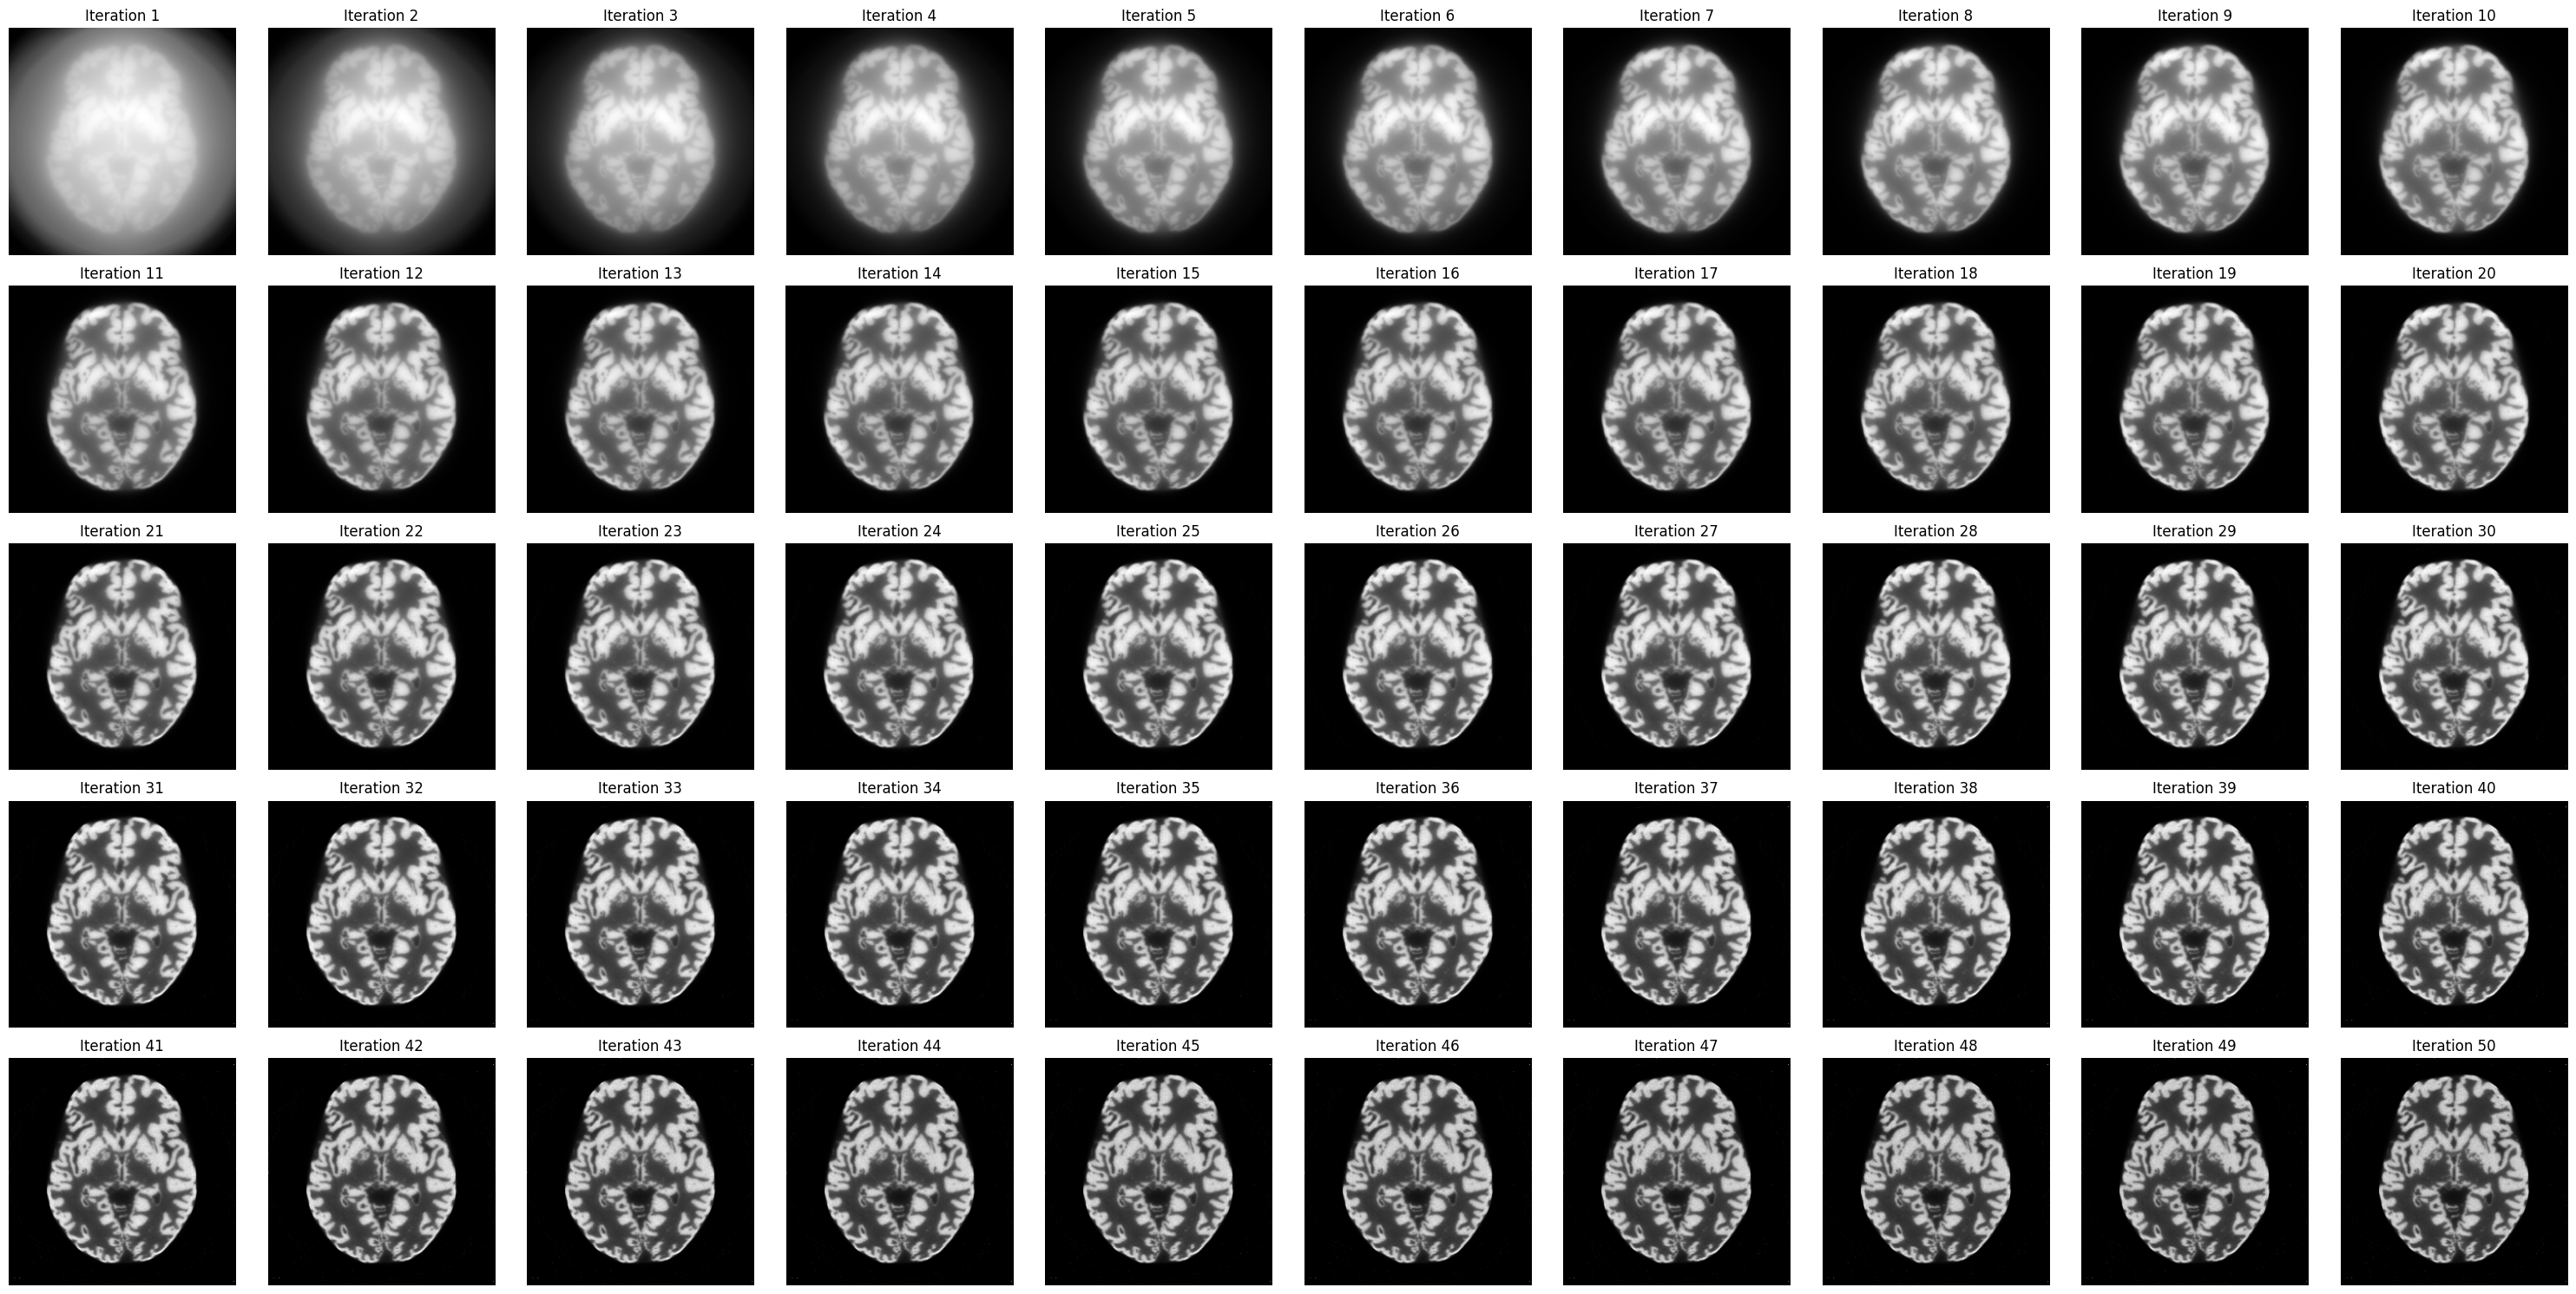

In [95]:
plot_50(image_loop_mapem)

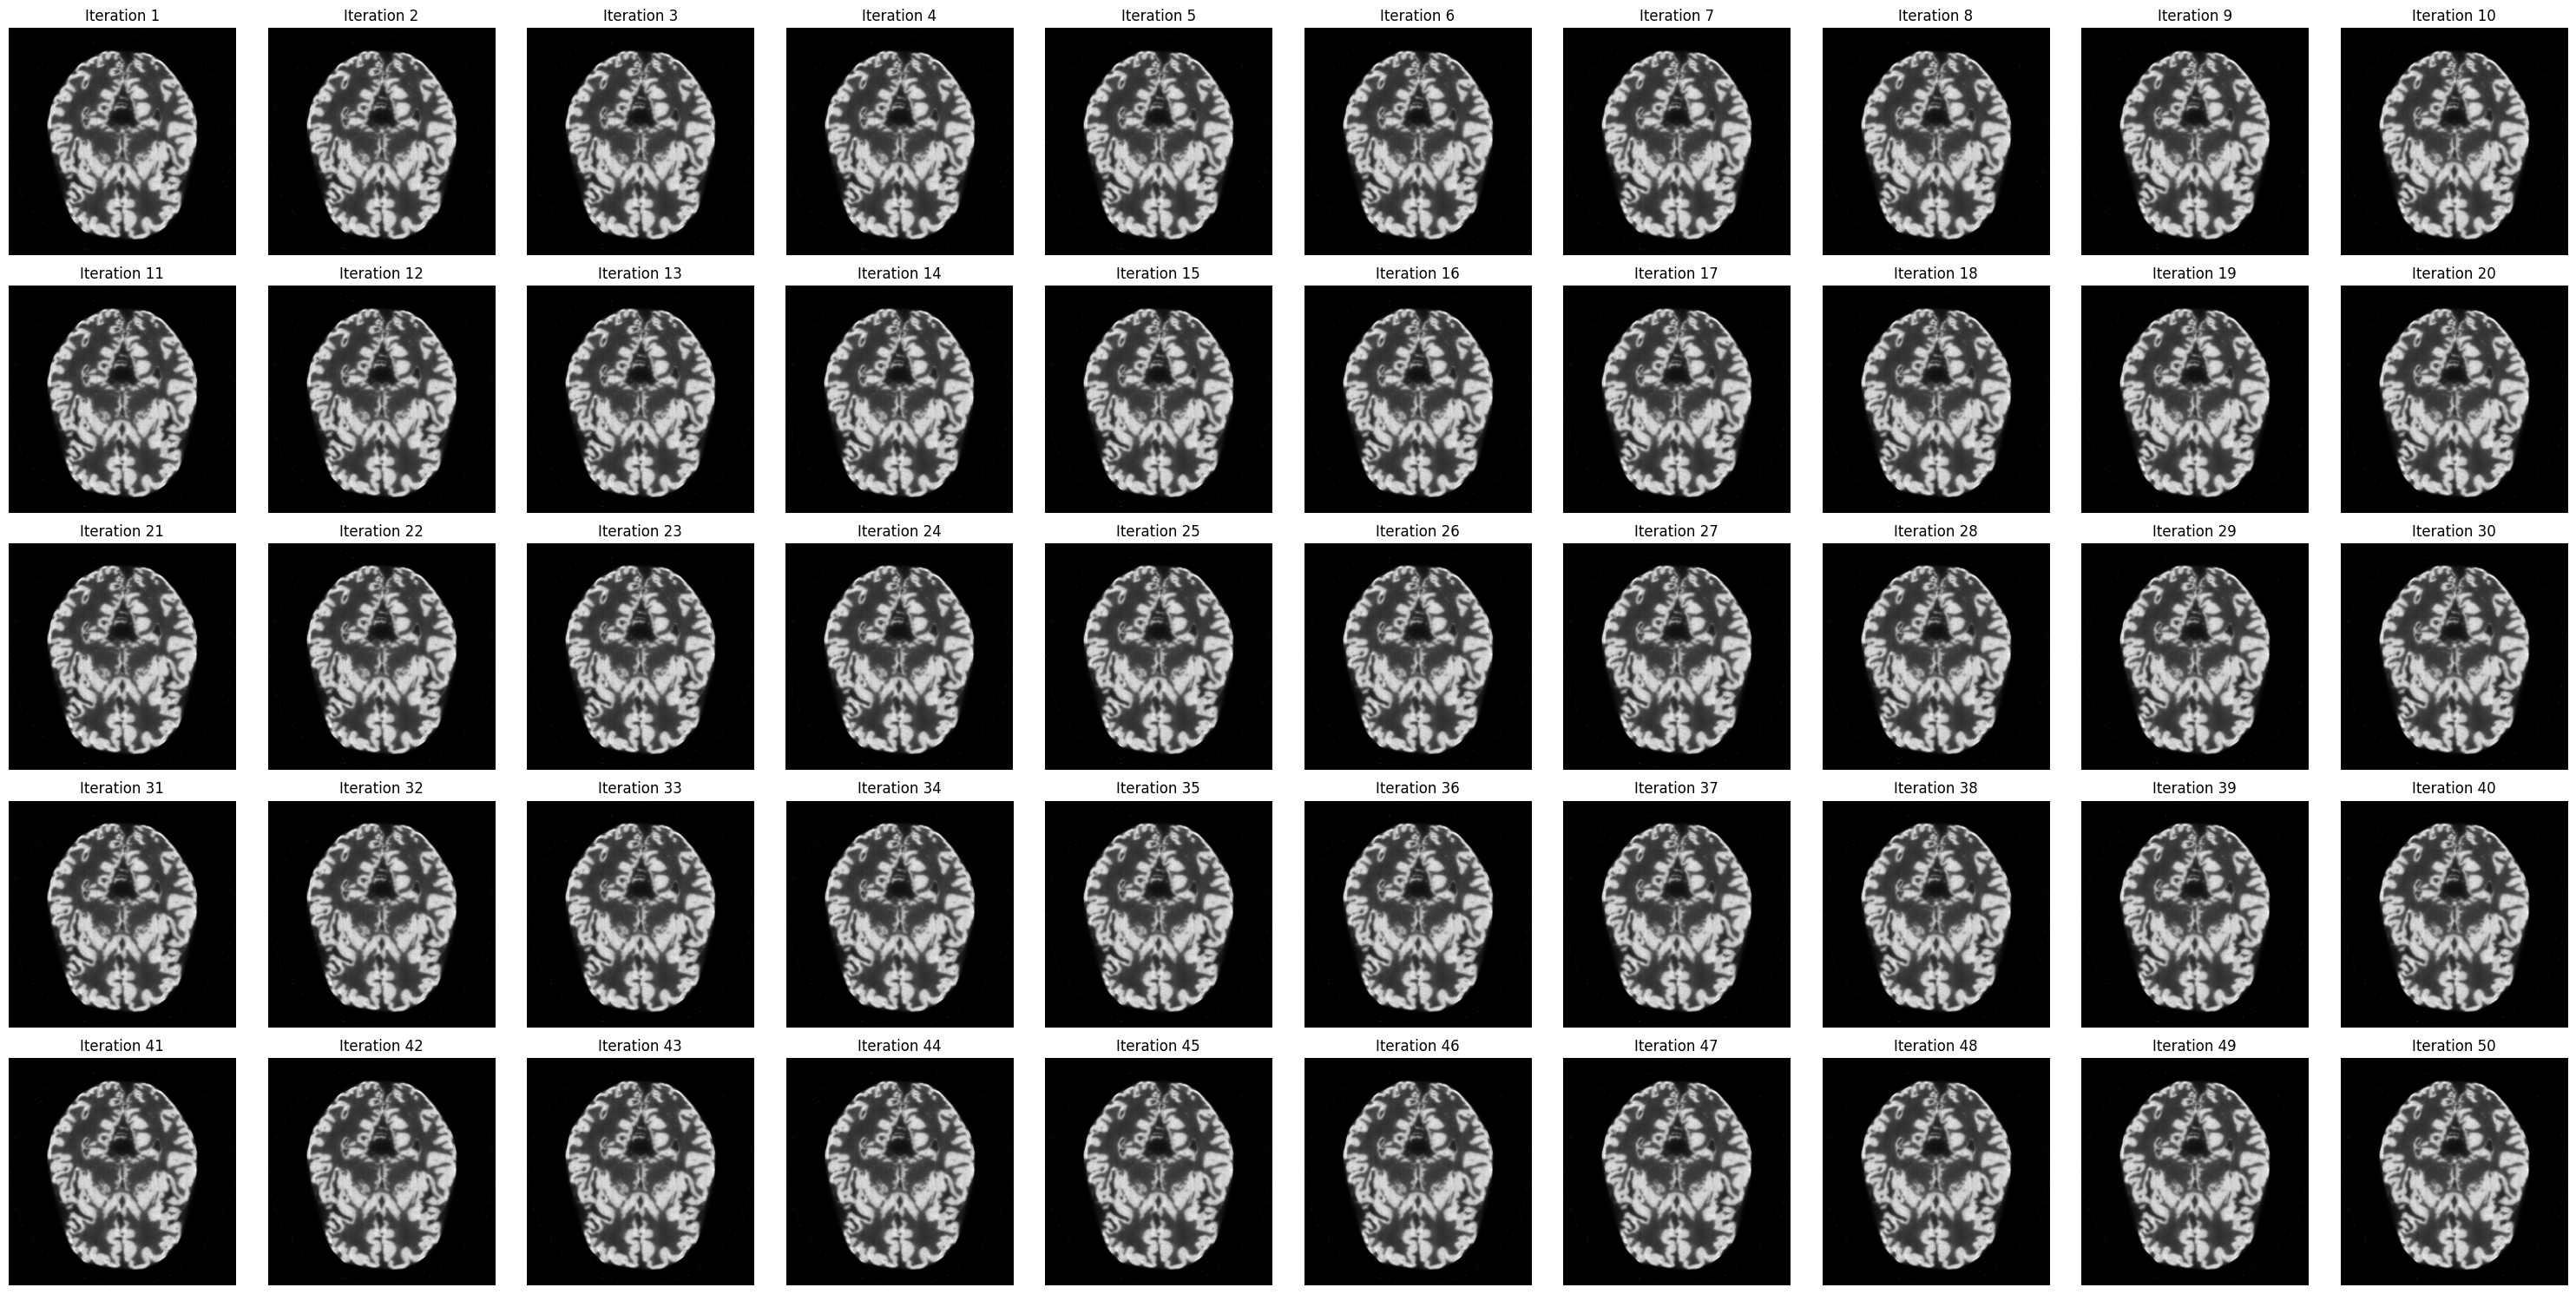

In [97]:
plot_50(image_loop_mlem_pack)

## Denoising

In [ ]:
from scipy.ndimage import gaussian_filter

def apply_gaussian_denoising(image, sigma):
    """
    Apply Gaussian denoising to an image.

    Parameters:
        image: 2D array
            Input noisy image.
        sigma: float
            Standard deviation for Gaussian kernel. Larger values result in more smoothing.

    Returns:
        denoised_image: 2D array
            Denoised image.
    """
    denoised_image = gaussian_filter(image, sigma=sigma)
    return denoised_image

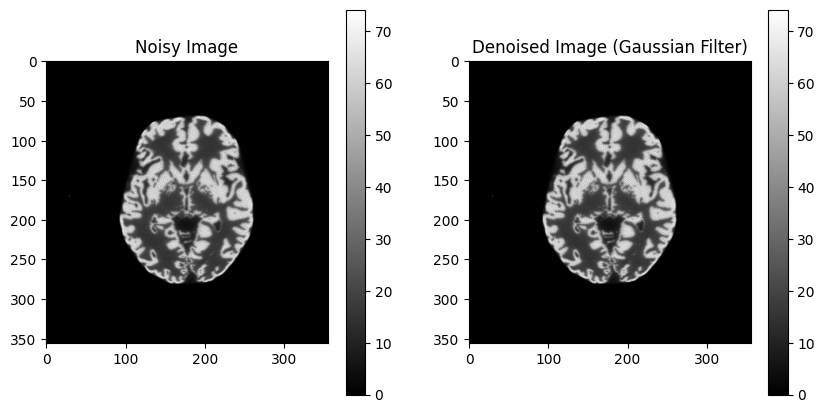

In [ ]:
# Example: Apply denoising to a noisy reconstruction
sigma = 0.0001  # Standard deviation for Gaussian kernel
noisy_image = training_data_mapem[0][0]  # Example noisy image
denoised_image = apply_gaussian_denoising(noisy_image, sigma)

# Visualize the denoising effect
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title("Noisy Image")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title("Denoised Image (Gaussian Filter)")
plt.colorbar()
plt.show()

## Notes

### What is Radon Transform? Any alternative?

The **Radon transform** is a mathematical operation that projects a 2D function (or image) into a set of 1D projections along multiple angles. It plays a fundamental role in tomographic imaging techniques like **Computed Tomography (CT)** and **Positron Emission Tomography (PET)**, where it is used to model the acquisition process of imaging systems.

---

#### **Definition**
The Radon transform of a 2D function $f(x, y)$ is defined as the integral of $f(x, y)$ along straight lines (or rays) at a given angle. Mathematically:

$$
R_\theta(p) = \int_{-\infty}^\infty f(p \cos \theta - t \sin \theta, p \sin \theta + t \cos \theta) \, dt
$$

Where:
- $R_\theta(p)$: The Radon transform at angle $\theta$ and distance $p$ from the origin.
- $p$: The perpendicular distance of the line from the origin.
- $\theta$: The angle of the line relative to the x-axis.
- $t$: The integration variable, parameterizing points along the line.

---

#### **Explanation**
1. **Input**:
   - A 2D image or function $f(x, y)$.
2. **Output**:
   - A set of 1D projections $R_\theta(p)$, one for each angle $\theta$.
3. **Geometric Interpretation**:
   - Imagine a parallel beam of rays passing through the image at a particular angle $\theta$.
   - The sum of the pixel values along each ray forms a single point in the Radon transform.

---

#### **Applications**
1. **Medical Imaging**:
   - Used in CT, PET, and SPECT imaging to model the acquisition of projection data.
   - The inverse Radon transform reconstructs 2D or 3D images from these projections.
2. **Seismic Imaging**:
   - Helps analyze wave propagation in geophysics.
3. **Image Processing**:
   - Used for detecting linear structures or simulating imaging systems.

---

#### **How It Works in PET**
In PET imaging:
- A radiotracer emits positrons, which annihilate and emit gamma photons in opposite directions.
- Detectors measure these photons along lines of response (LoRs), effectively forming projections at different angles.
- The Radon transform mathematically models these projections.

---

#### **Visualization**
For a simple image (e.g., a circle), the Radon transform at different angles generates a sinogram. Each column of the sinogram corresponds to a 1D projection at a specific angle.

Would you like to explore a practical implementation or visualization of the Radon transform?


Yes, there are alternative algorithms and techniques that achieve similar effects to the **Radon transform** by modeling projections or integrating data along certain paths. These methods are often used in imaging and signal processing fields, including medical imaging, computer vision, and geosciences.

---

#### **1. Hough Transform**
- **Purpose**: Detects shapes (e.g., lines, circles) in images.
- **How It Works**:
  - The Hough transform maps edge points in the spatial domain to a parameter space (e.g., slope and intercept for lines).
  - Similar to the Radon transform in detecting linear structures.
- **Difference**: The Hough transform is discrete and focuses on feature detection rather than continuous projection.

---

#### **2. Discrete Fourier Transform (DFT)**
- **Purpose**: Analyzes frequency components of signals and images.
- **How It Relates**:
  - The **Fourier Slice Theorem** states that the 1D Fourier transform of a projection (line integral) of an image corresponds to a slice of the 2D Fourier transform of the image.
  - This relationship allows reconstruction from projections without explicitly using the Radon transform.
- **Difference**: Operates in the frequency domain rather than the spatial domain.

---

#### **3. Wavelet Transform**
- **Purpose**: Analyzes localized frequency content in images.
- **How It Relates**:
  - Wavelet transforms can decompose an image into components, highlighting features like edges or ridges that may align with projection paths.
  - Useful for compressing or denoising sinograms.
- **Difference**: Decomposes the image hierarchically instead of integrating along lines.

---

#### **4. Line Integrals in Discrete Geometry**
- **Purpose**: Models projections directly by summing values along predefined paths.
- **How It Works**:
  - Instead of rotating the image (as in the Radon transform), the algorithm sums pixel values along predefined grid paths using interpolation.
  - Often used in ray-tracing simulations and direct integration for CT/PET systems.
- **Difference**: Directly computes discrete line integrals without requiring the continuous Radon transform.

---

#### **5. Algebraic Reconstruction Techniques (ART)**
- **Purpose**: Reconstructs images from projections iteratively.
- **How It Works**:
  - Updates the reconstruction iteratively by minimizing the error between measured and computed projections.
  - Solves the inverse problem of image reconstruction directly.
- **Difference**: Iterative and algebraic, focusing on solving projection equations rather than computing the transform.

---

#### **6. Spherical or Cylindrical Harmonics**
- **Purpose**: Models projections in 3D or circular systems.
- **How It Relates**:
  - Useful for modeling radial or spherical data, such as in SPECT imaging or geophysical tomography.
- **Difference**: Designed for spherical or cylindrical domains rather than planar imaging.

---

#### **7. Backprojection without Radon**
- **Purpose**: Directly reconstruct images from projection data.
- **How It Works**:
  - Uses geometric algorithms to "smear" projection values back into the spatial domain without explicitly computing the Radon transform.
  - Often combined with filtering (e.g., Filtered Backprojection, FBP).
- **Difference**: Avoids explicit Radon computation, focusing on reconstruction.

---

#### **8. Machine Learning-Based Projections**
- **Purpose**: Simulates or reconstructs projections using neural networks.
- **How It Works**:
  - Trains models (e.g., U-Net, GAN) to learn mappings between images and their sinograms.
  - Neural networks can approximate projection operations without directly using mathematical transforms.
- **Difference**: Data-driven rather than explicitly mathematical.

---

#### **Choosing the Best Approach**
- **For Medical Imaging**:
  - Radon transform and Algebraic Reconstruction Techniques are widely used.
- **For Image Processing**:
  - Hough transform is effective for detecting structures.
- **For Frequency Domain Analysis**:
  - Fourier transform is a strong alternative.


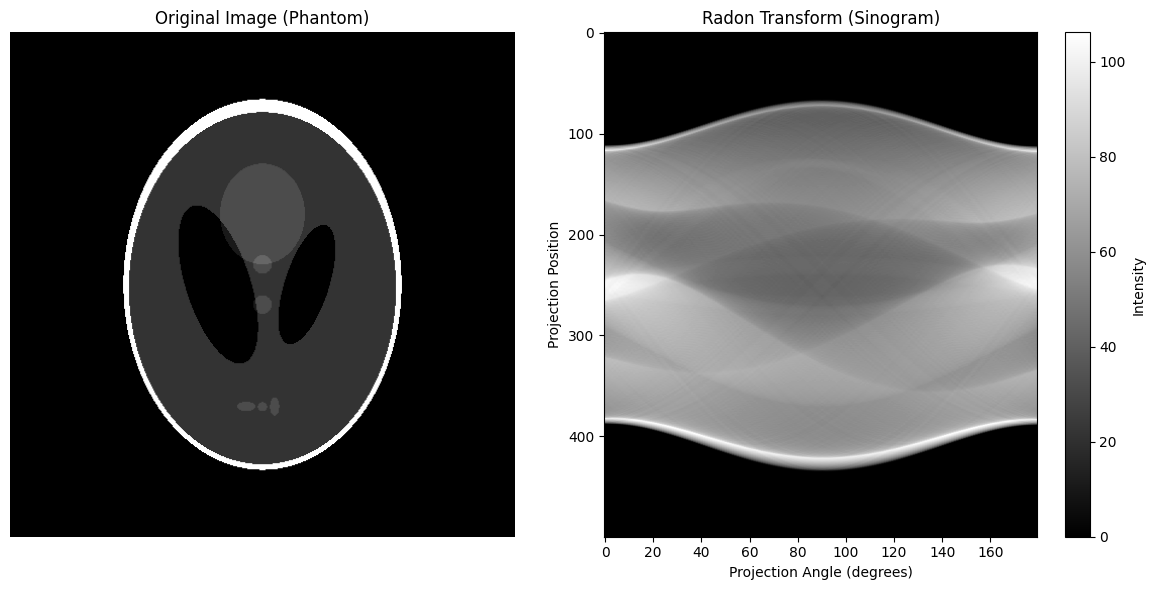

In [ ]:
# Re-importing libraries for Radon transform visualization
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon

# Generate a phantom image (Shepp-Logan Phantom)
image = shepp_logan_phantom()
image = np.pad(image, ((50, 50), (50, 50)), mode='constant')  # Pad to make it larger

# Define angles for the Radon transform
angles = np.linspace(0, 180, 180, endpoint=False)

# Perform the Radon transform
sinogram = radon(image, theta=angles, circle=True)

# Visualize the original image and its Radon transform (sinogram)
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image (Phantom)")
plt.axis('off')

# Sinogram
plt.subplot(1, 2, 2)
plt.imshow(sinogram, cmap='gray', aspect='auto')
plt.title("Radon Transform (Sinogram)")
plt.xlabel("Projection Angle (degrees)")
plt.ylabel("Projection Position")
plt.colorbar(label="Intensity")

plt.tight_layout()
plt.show()